<a href="https://colab.research.google.com/github/Felista-Mueni/Felista-Mueni/blob/main/Capacity_planning_using_Prophets_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Summary: Rebuilding the top performing models (focusing on LSTM) to make sure that they are all correct (sanity check)

Model list: Prophet (Fixed)

### Import libraries ###

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from pandas.tseries.holiday import USFederalHolidayCalendar
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

#prophet 
import copy
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
import holidays

#LSTM
import math
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Read in data ###

In [ ]:
# read in plk file
df = pd.read_pickle(r'/content/drive/My Drive/GDL - Cohort 18 Collaboration Drive/Project Files/C18_1 Notebooks/Processed Data/CapacityPlanning.pkl')
df

NumUsersWorking  ActivityTime  Utilization  \
DepartmentName    ActivityDate                                               
CDO               2021-06-10                  1     10.584758    10.584758   
                  2021-06-11                  1      9.751983     9.751983   
                  2021-06-14                  1      6.246132     6.246132   
                  2021-06-15                  1     10.780587    10.780587   
                  2021-06-16                  1     10.800301    10.800301   
...                                         ...           ...          ...   
Wealth Management 2022-11-04                 29    171.505642     5.913988   
                  2022-11-07                 32    183.812944     5.744154   
                  2022-11-08                 32    182.867156     5.714599   
                  2022-11-09                 35    190.883835     5.453824   
                  2022-11-10                 36    199.396016     5.538778   

                                ActivityTimeMA  UtilizationMA  \
DepartmentName    ActivityDate                                  
CDO               2021-06-10          0.000000       0.000000   
                  2021-06-11          0.000000       0.000000   
                  2021-06-14          0.000000       0.000000   
                  2021-06-15          0.000000       0.000000   
                  2021-06-16          0.000000       0.000000   
...                                        ...            ...   
Wealth Management 2022-11-04        202.306376       5.775303   
                  2022-11-07        201.058929       5.811372   
                  2022-11-08        198.814203       5.845708   
                  2022-11-09        194.748991       5.859777   
                  2022-11-10        186.015957       5.747726   

                                ActivityTimeRes  UtilizationRes  \
DepartmentName    ActivityDate                                    
CDO               2021-06-10           0.000000        0.000000   
                  2021-06-11           0.000000        0.000000   
                  2021-06-14           0.000000        0.000000   
                  2021-06-15           0.000000        0.000000   
                  2021-06-16           0.000000        0.000000   
...                                         ...             ...   
Wealth Management 2022-11-04         -30.800734        0.138685   
                  2022-11-07         -17.245985       -0.067217   
                  2022-11-08         -15.947047       -0.131109   
                  2022-11-09          -3.865155       -0.405953   
                  2022-11-10          13.380059       -0.208948   

                                (ActivityTime, Browsing)  \
DepartmentName    ActivityDate                             
CDO               2021-06-10                    0.093891   
                  2021-06-11                    0.010278   
                  2021-06-14                    0.008333   
                  2021-06-15                    0.034167   
                  2021-06-16                    0.592499   
...                                                  ...   
Wealth Management 2022-11-04                    4.250305   
                  2022-11-07                    7.204210   
                  2022-11-08                    5.839763   
                  2022-11-09                   10.688668   
                  2022-11-10                   10.764220   

                                (ActivityTime, Communication)  \
DepartmentName    ActivityDate                                  
CDO               2021-06-10                         1.978619   
                  2021-06-11                         1.548339   
                  2021-06-14                         1.697782   
                  2021-06-15                         3.197231   
                  2021-06-16                         1.452225   
...                                                       ...  

In [ ]:
# helper functions to get ultilization column 
def get_department(df, depname):
  dep = df[df.index.get_level_values(0)==depname]
  dep = dep.droplevel(level=0).reset_index()
  return dep

def graph_department(dep, depname):
  date = 'ActivityDate'
  size = dep.shape[0]
  feature = 'Utilization'
  tick = size//10

  plt.figure(figsize=(20, 6), dpi=80)
  ticks = list(dep[date])
  plt.plot(ticks, dep[feature])
  plt.xticks([ticks[i] for i in range(len(ticks)) if i % tick == 0], rotation='horizontal')
  plt.title(str(size) + ' samples of ' + depname)
  plt.show()

In [ ]:
# get data by departments 
gsf = get_department(df, 'GSF')
ctdcs = get_department(df, 'CT DCS')
ctde = get_department(df, 'CT Default')
gfc = get_department(df, 'Global Fund Custody')
ttss = get_department(df, 'TTSS')
ss = get_department(df, 'Shared Services')
cme = get_department(df, 'CME')
itc = get_department(df, 'ITC')
cdo = get_department(df, 'CDO')
wm = get_department(df, 'Wealth Management')
fa = get_department(df, 'Fund Accounting')
dep = [gsf, ctdcs, ctde, gfc, ttss, ss, cme, itc, cdo, wm, fa]
depname = ['GSF', 'CT DCS', 'CT Default', 'Global Fund Custody', 'TTSS', 'Shared Services', 'CME', 'ITC', 'CDO', 'Wealth Management', 'Fund Accounting']

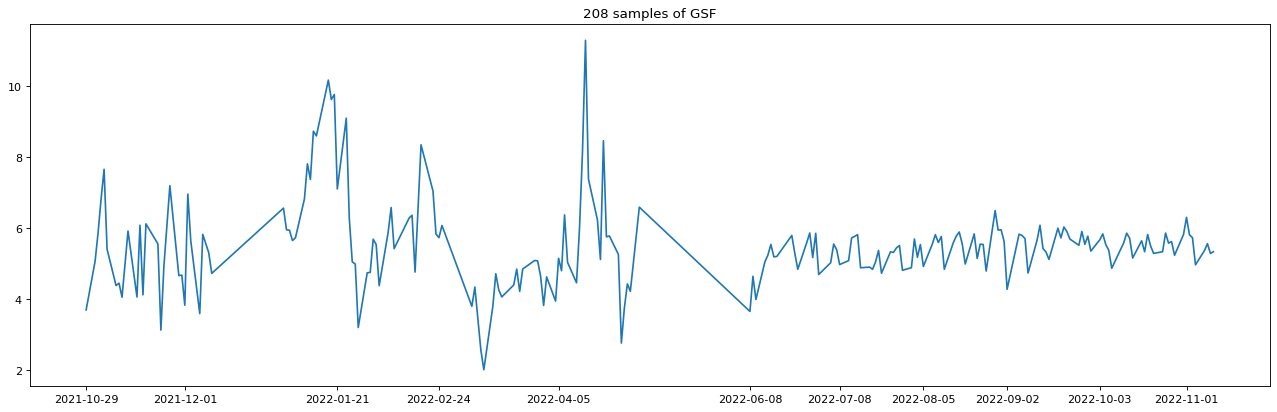

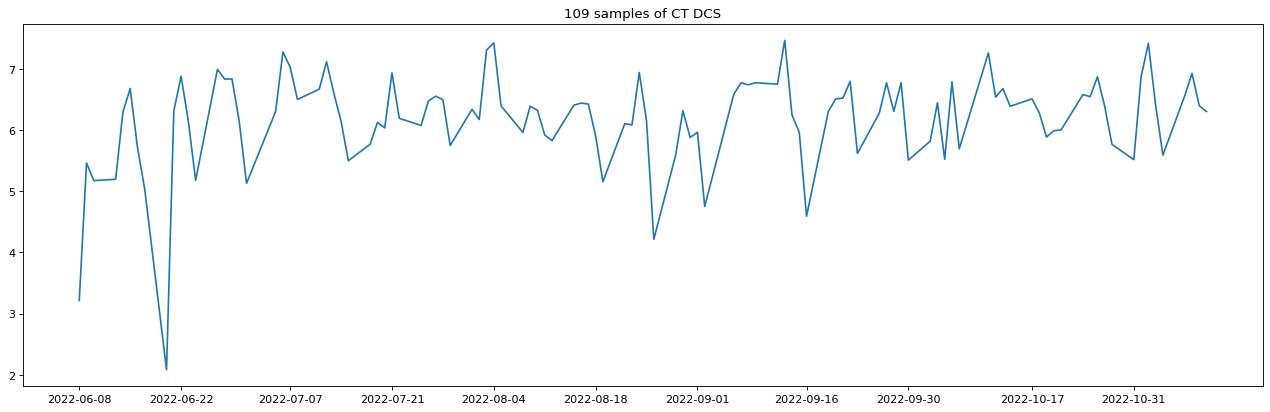

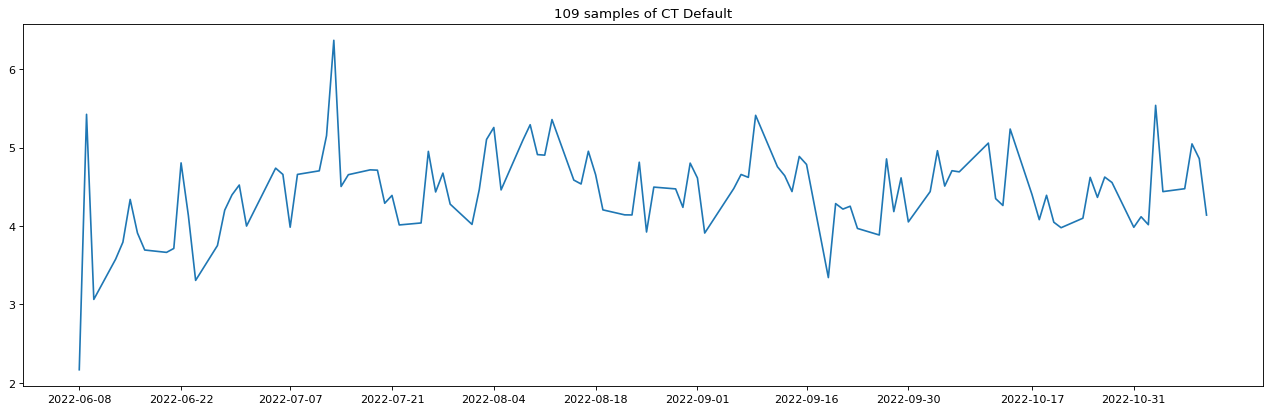

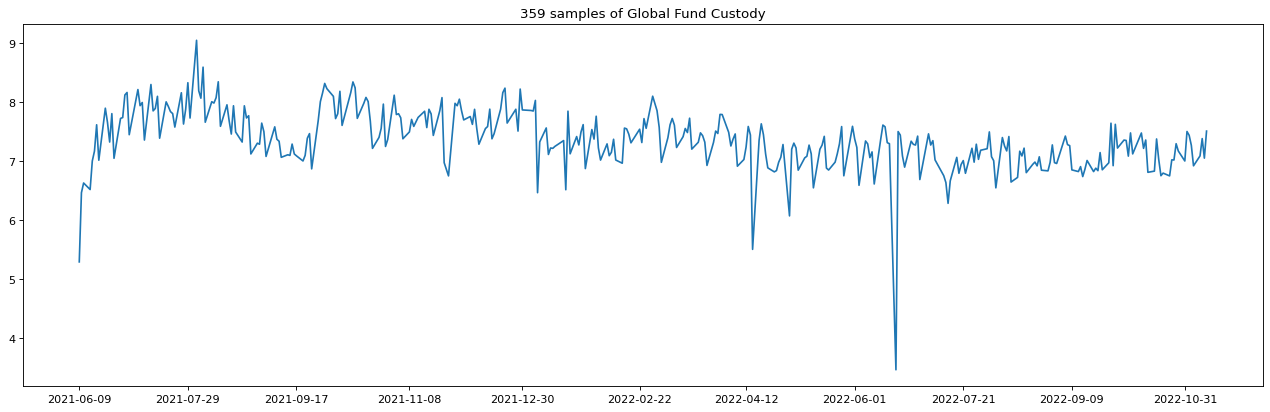

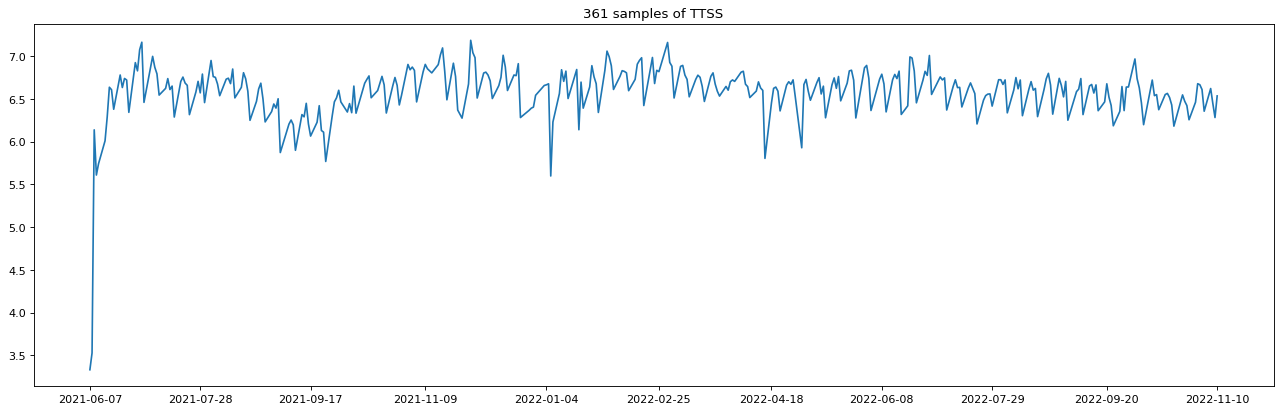

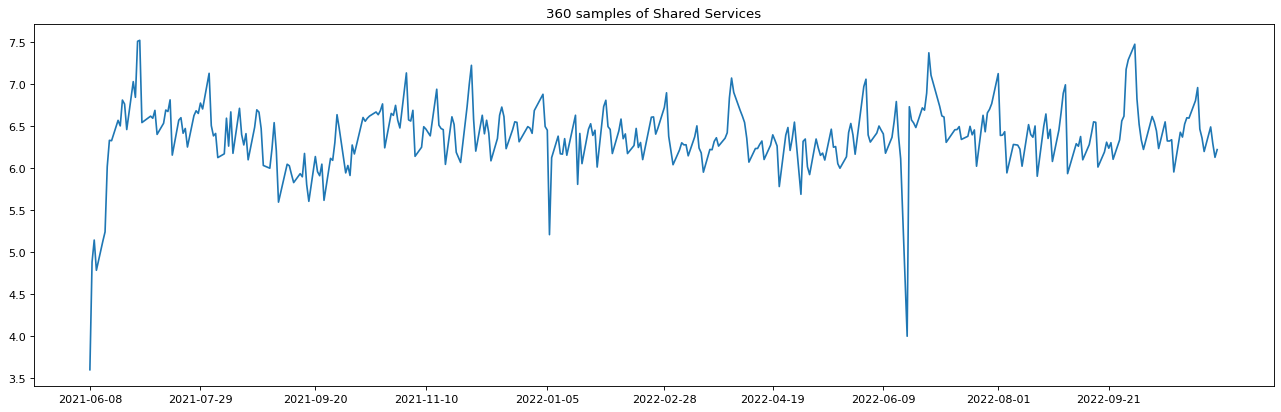

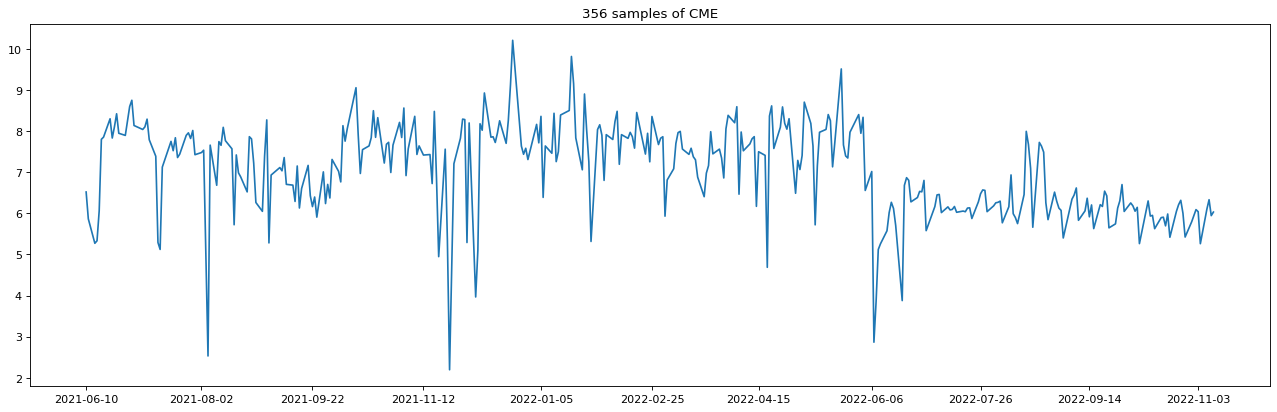

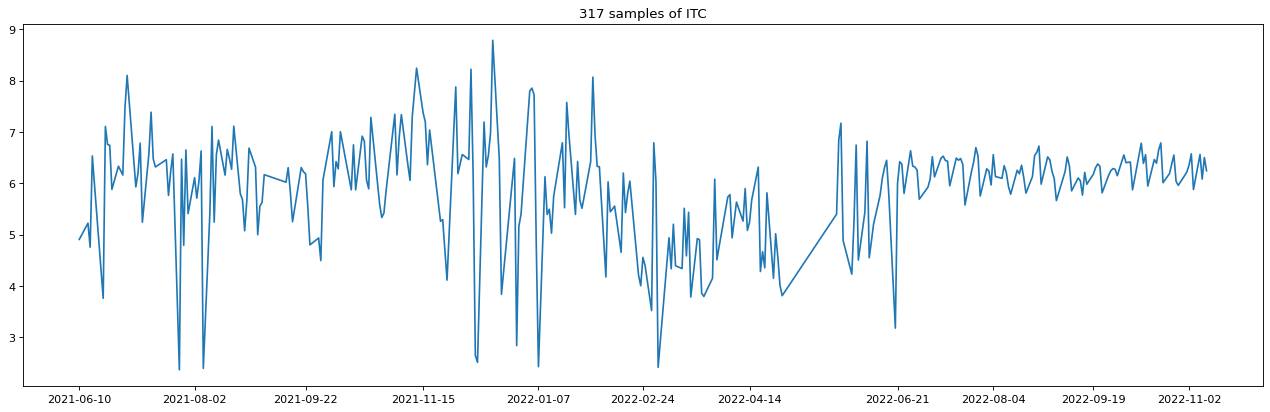

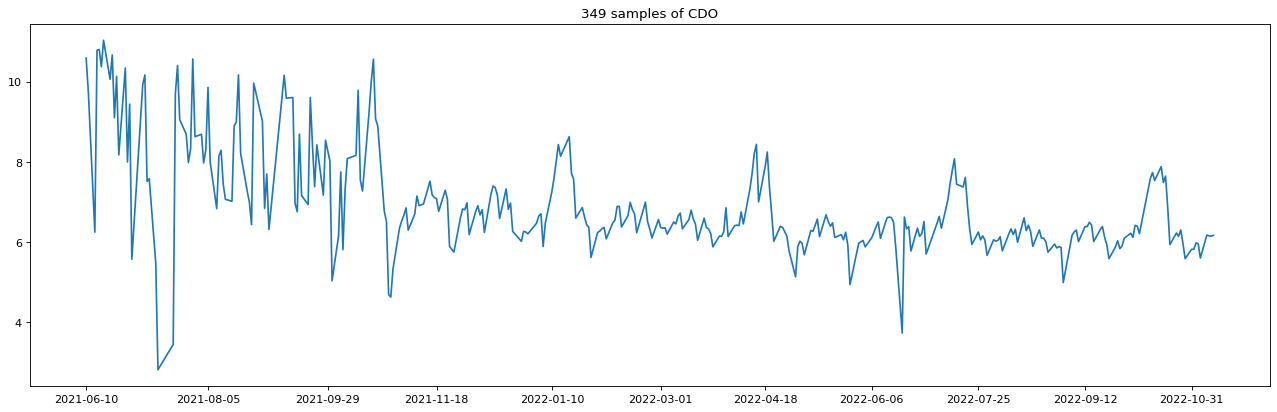

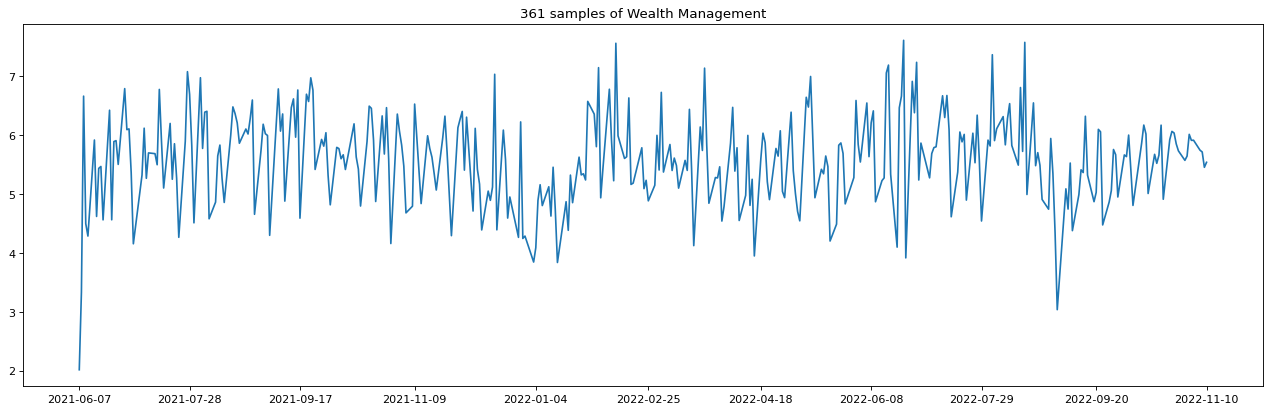

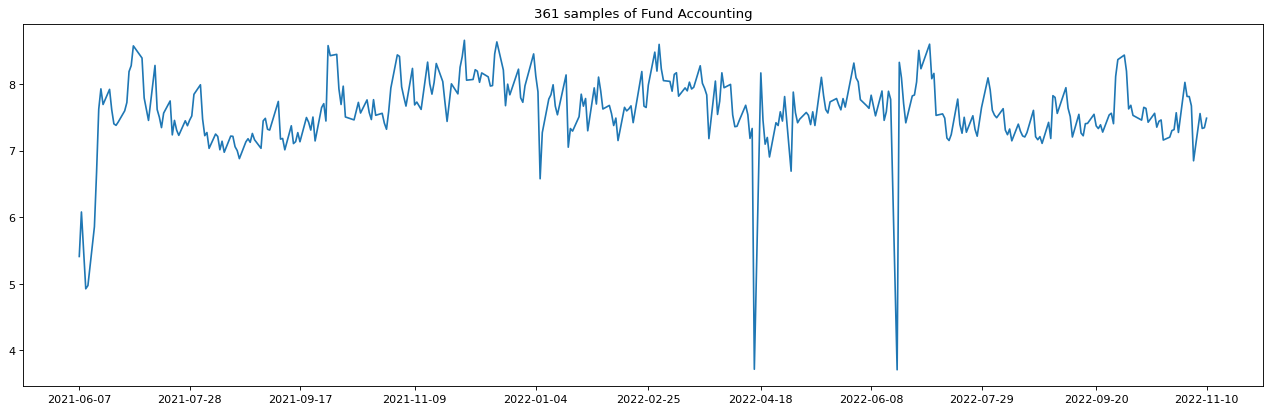

In [ ]:
for idx, d in enumerate(dep):
  graph_department(d, depname[idx])

### Setting global variables ###

In [ ]:
# number of days to generate predictions #
forecast_days = 60

# holdays years for Prophet model
years = [2020, 2021, 2022]

### Prophet ###

In [ ]:
def give_hols(years):
  holiday_us = holidays.US(years=years)
  holiday_ca = holidays.CA(years=years)
  holiday_in = holidays.India(years=years)

  hols = holiday_us + holiday_ca + holiday_in
  hols = pd.DataFrame.from_dict(hols, orient="index").reset_index()
  hols.columns = ['ds', 'holiday']
  hols.head()

  return hols

def create_prophet(data, num_forecast, hols):
  m = Prophet(changepoint_prior_scale=0.05, holidays = hols)
  m.add_seasonality(name = 'quarterly', period = 90, fourier_order = 3)
  m.add_seasonality(name = 'monthly', period = 30.5, fourier_order = 4)
  m.add_seasonality(name = 'weekly', period = 5, fourier_order = 2)

  df_prophet = copy.deepcopy(data)
  df_prophet.columns = ['ds', 'y']
  train = df_prophet[:-num_forecast]
  m.fit(train)
  future = m.make_future_dataframe(periods=num_forecast, freq = "B")

  return train, future, m

def log_error_prophet(df, forecast):
  feature = 'Utilization'
  error_log = []
  for i in range(1, forecast_days + 1):
    if i == 1:
      error_log.append(round(mean_squared_error(df[feature][-forecast_days:(-forecast_days+1)], forecast['yhat'][-forecast_days:(-forecast_days+1)]),4))
    elif i == forecast_days:
      error_log.append(round(mean_squared_error(df[feature][-forecast_days:], forecast['yhat'][-forecast_days:]),4))
    elif i % 5 == 0:
      error_log.append(round(mean_squared_error(df[feature][-forecast_days:(-forecast_days+i)], forecast['yhat'][-forecast_days:(-forecast_days+i)]),4))


  return error_log

def get_prophet_prediction(df, forecast):
  predictions = pd.DataFrame()
  predictions['ActivityDate'] = df['ActivityDate'][-forecast_days:]
  predictions['Utilization'] = forecast['yhat'][-forecast_days:]
  return predictions

def graph_result_prophet(df, forecast, depname):
  date = 'ActivityDate'
  # size = df.shape[0]
  feature = 'Utilization'
  # tick = size//10
  # predicted = df[feature][:-30].append(forecast['yhat'][-30:])
  plt.figure(figsize=(20, 6), dpi=80)
  ticks = list(df[date][-forecast_days:])
  plt.plot(ticks, forecast['yhat'][-forecast_days:], label = 'Predicted')
  plt.plot(ticks, df[feature][-forecast_days:], label = 'Actual')
  #plt.xticks([ticks[i] for i in range(len(ticks)) if i % tick == 0], rotation='horizontal')
  plt.title('Actual vs Predicted Zoomed In '+depname)
  plt.legend()
  plt.show()

def graph_whole_department_prophet(df, forecast, depname):
  date = 'ActivityDate'
  # size = df.shape[0]
  feature = 'Utilization'
  # tick = size//10
  predicted = df[feature][:-forecast_days].append(forecast['yhat'][-forecast_days:])
  plt.figure(figsize=(20, 6), dpi=80)
  ticks = list(df[date])
  plt.plot(ticks, predicted, label = 'Predicted')
  plt.plot(ticks, df[feature], label = 'Actual')
  #plt.xticks([ticks[i] for i in range(len(ticks)) if i % tick == 0], rotation='horizontal')
  plt.title('Actual vs Predicted All Data '+depname)
  plt.legend()
  plt.show()



INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphbk9qep0/48wj2jcu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphbk9qep0/1y5hphjv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=981', 'data', 'file=/tmp/tmphbk9qep0/48wj2jcu.json', 'init=/tmp/tmphbk9qep0/1y5hphjv.json', 'output', 'file=/tmp/tmphbk9qep0/prophet_model50p95smk/prophet_model-20230210123449.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:34:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:34:49 - cmdstanpy - INFO - Chain [1] done 

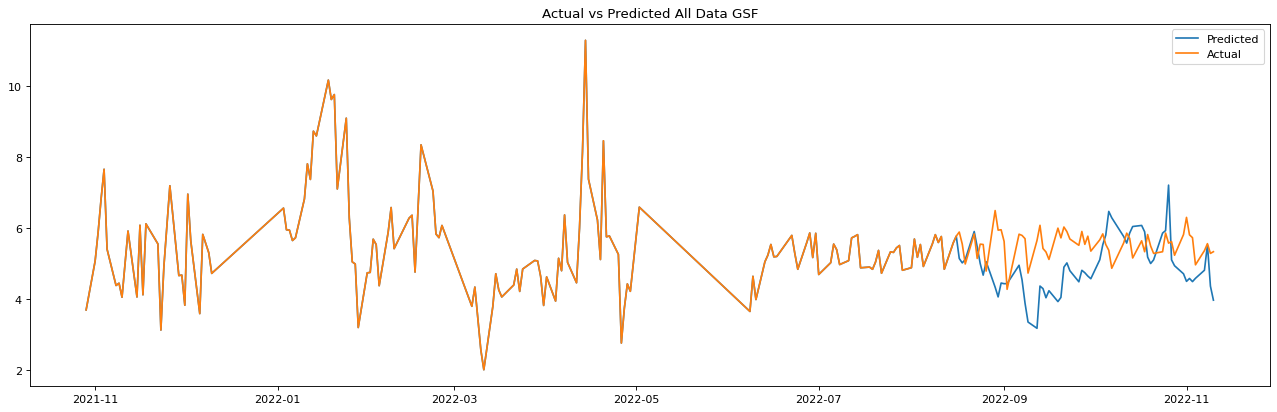

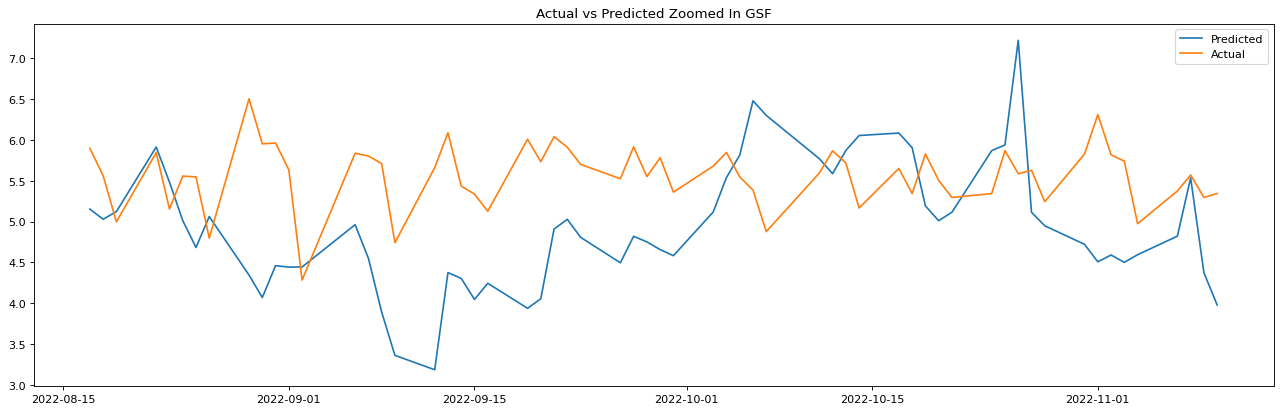

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphbk9qep0/jqy7bb49.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphbk9qep0/dv3keck6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91719', 'data', 'file=/tmp/tmphbk9qep0/jqy7bb49.json', 'init=/tmp/tmphbk9qep0/dv3keck6.json', 'output', 'file=/tmp/tmphbk9qep0/prophet_modelfxefsvw7/prophet_model-20230210123451.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
12:34:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:34:53 - cmdstanpy - INFO - Chain [1] do

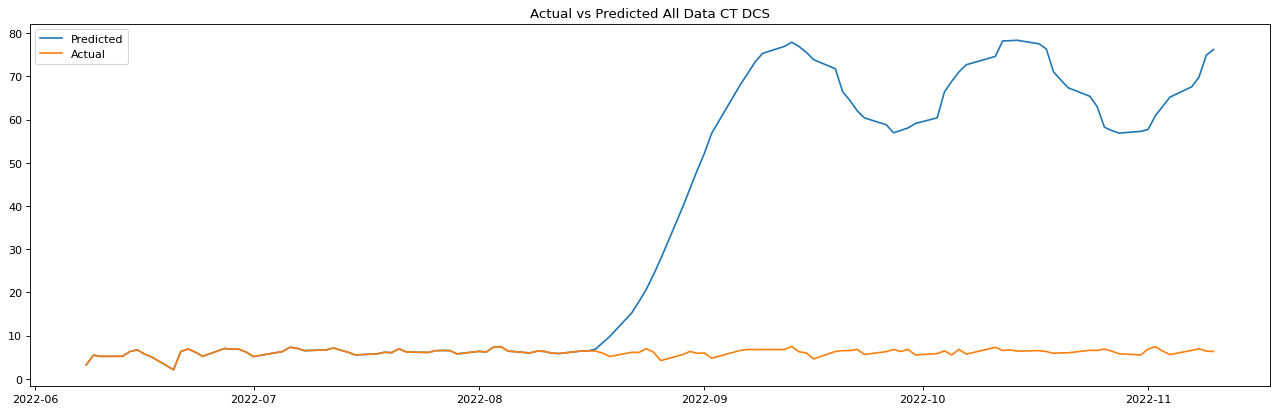

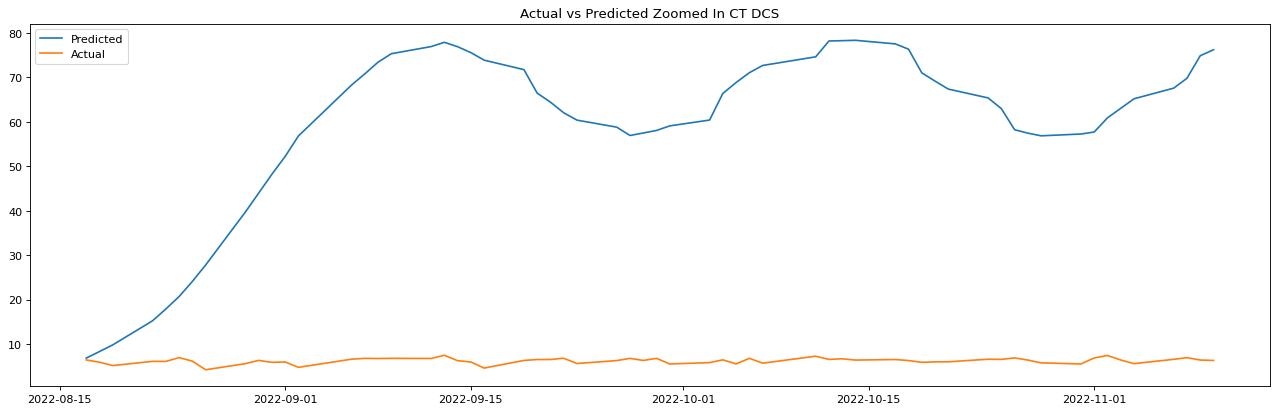

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphbk9qep0/mztj9i3y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphbk9qep0/2yim2yqw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44134', 'data', 'file=/tmp/tmphbk9qep0/mztj9i3y.json', 'init=/tmp/tmphbk9qep0/2yim2yqw.json', 'output', 'file=/tmp/tmphbk9qep0/prophet_modelcwql_rqa/prophet_model-20230210123454.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
12:34:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:34:54 - cmdstanpy - INFO - Chain [1] do

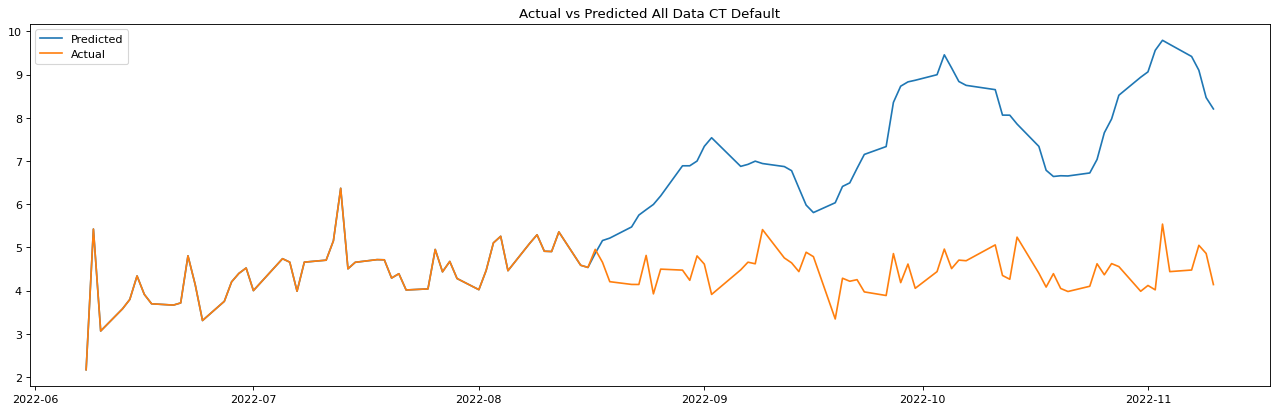

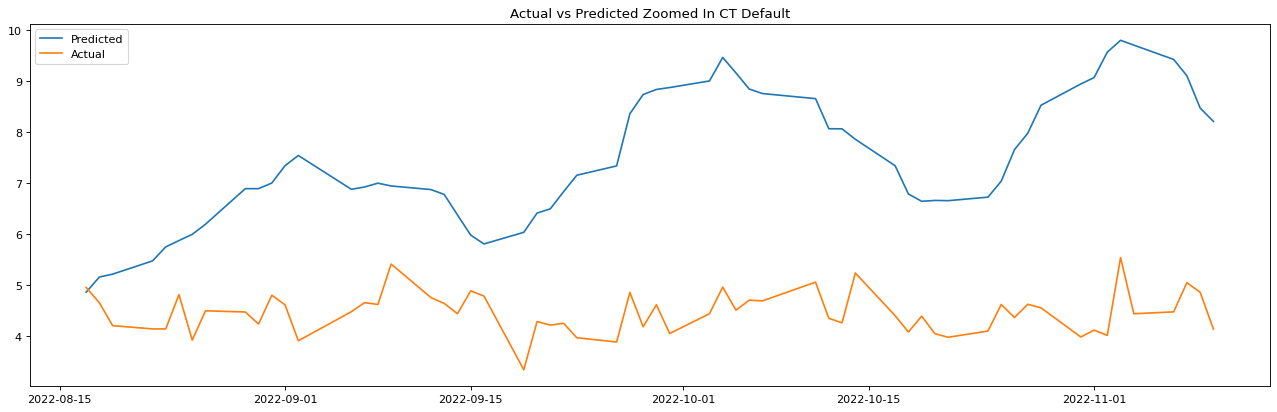

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphbk9qep0/q1qejdjt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphbk9qep0/cncfzrvy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91294', 'data', 'file=/tmp/tmphbk9qep0/q1qejdjt.json', 'init=/tmp/tmphbk9qep0/cncfzrvy.json', 'output', 'file=/tmp/tmphbk9qep0/prophet_modelklj53uj6/prophet_model-20230210123455.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:34:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:34:55 - cmdstanpy - INFO - Chain [1] don

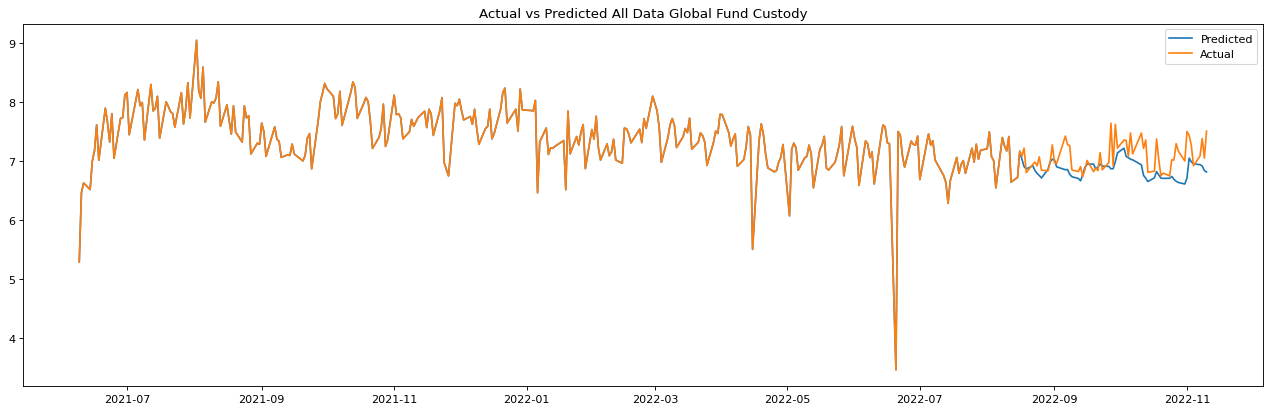

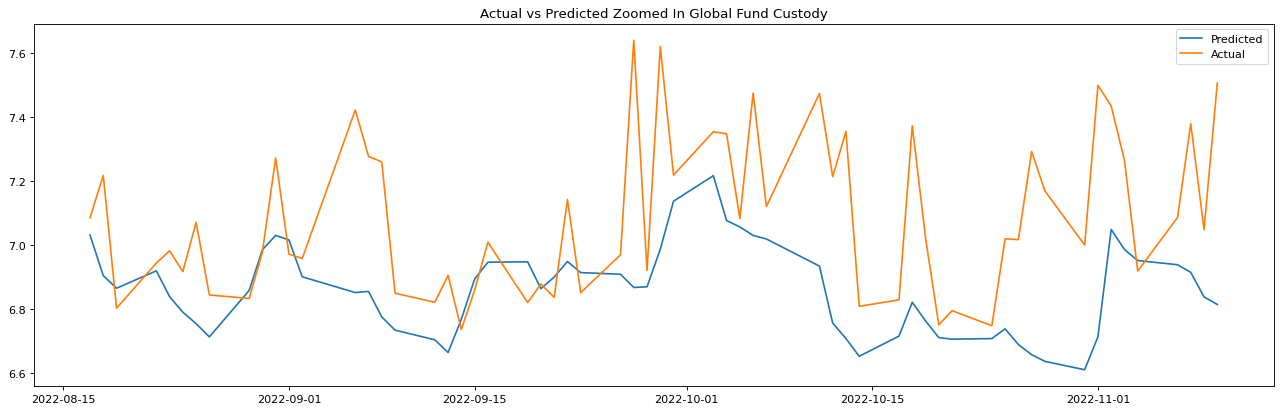

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphbk9qep0/6wa_h99o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphbk9qep0/qq2pjmf3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70756', 'data', 'file=/tmp/tmphbk9qep0/6wa_h99o.json', 'init=/tmp/tmphbk9qep0/qq2pjmf3.json', 'output', 'file=/tmp/tmphbk9qep0/prophet_model13l4bwrd/prophet_model-20230210123457.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:34:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:34:57 - cmdstanpy - INFO - Chain [1] don

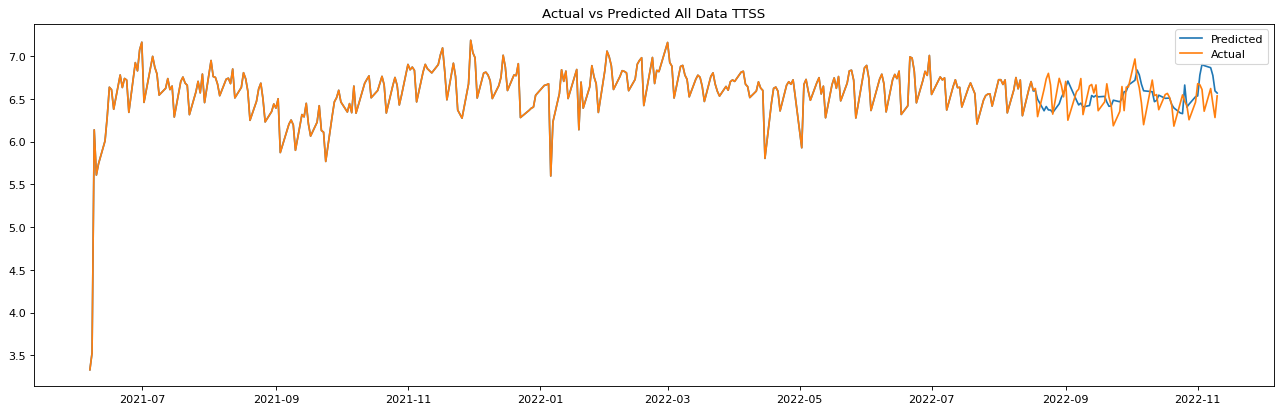

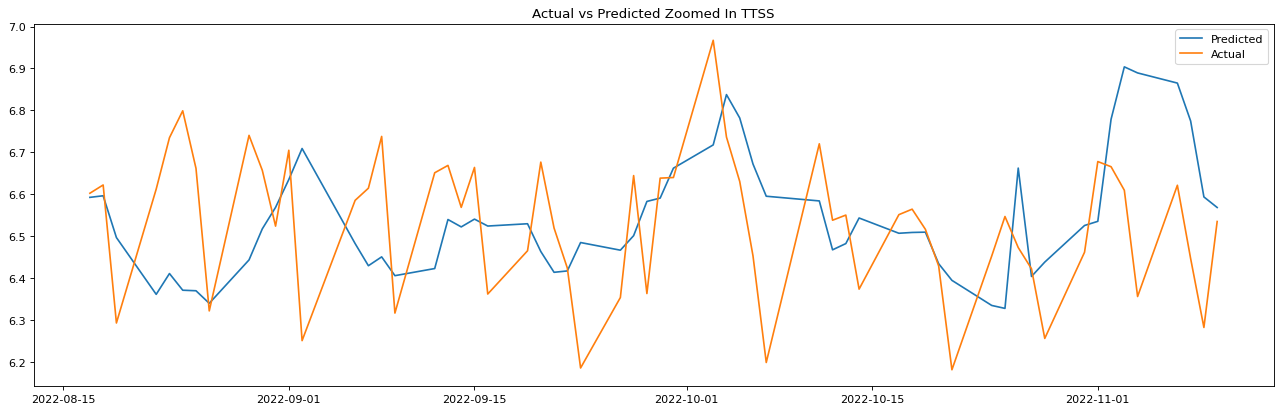

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphbk9qep0/jijv29oi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphbk9qep0/gf9g5yuv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71454', 'data', 'file=/tmp/tmphbk9qep0/jijv29oi.json', 'init=/tmp/tmphbk9qep0/gf9g5yuv.json', 'output', 'file=/tmp/tmphbk9qep0/prophet_modelik9q1yav/prophet_model-20230210123458.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:34:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:34:58 - cmdstanpy - INFO - Chain [1] don

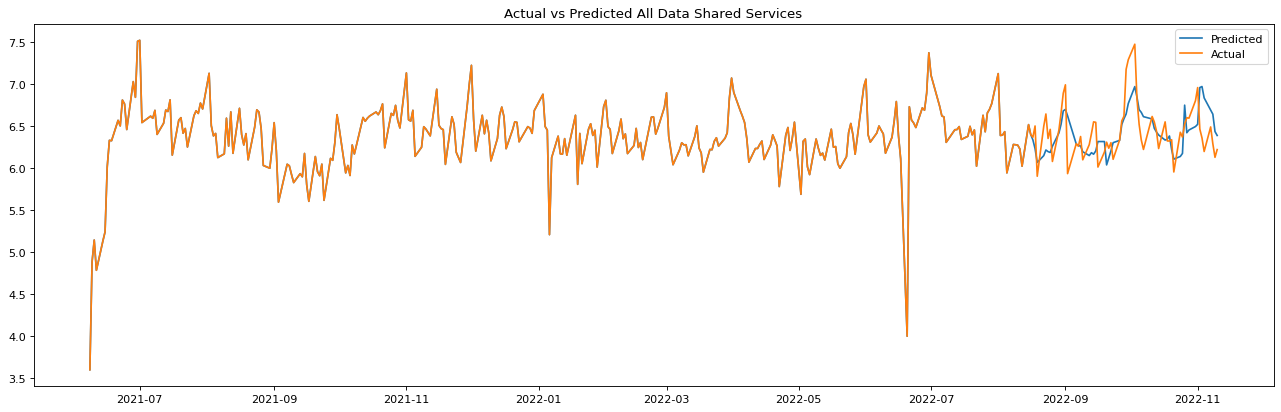

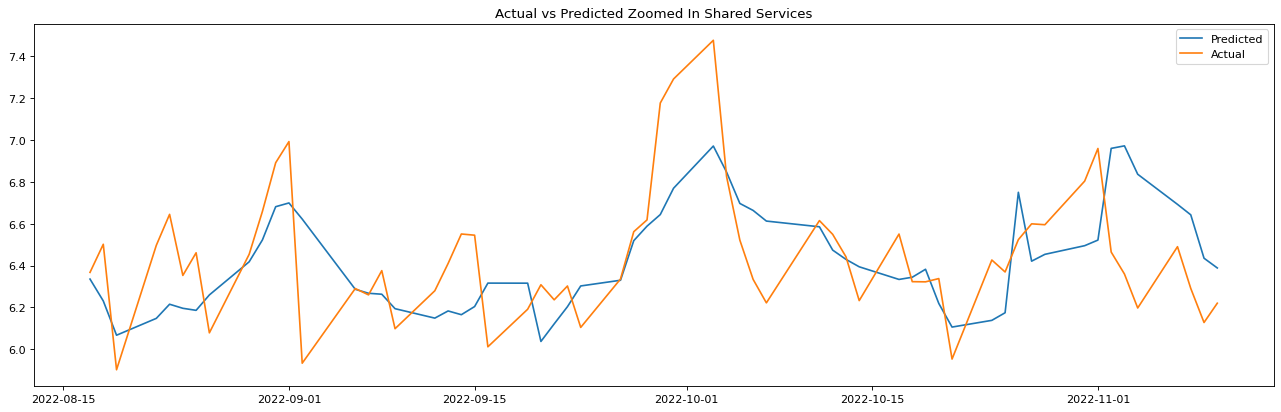

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphbk9qep0/3yhat8y6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphbk9qep0/k0z5i4w9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4047', 'data', 'file=/tmp/tmphbk9qep0/3yhat8y6.json', 'init=/tmp/tmphbk9qep0/k0z5i4w9.json', 'output', 'file=/tmp/tmphbk9qep0/prophet_modelevcej02f/prophet_model-20230210123459.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:34:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:34:59 - cmdstanpy - INFO - Chain [1] done

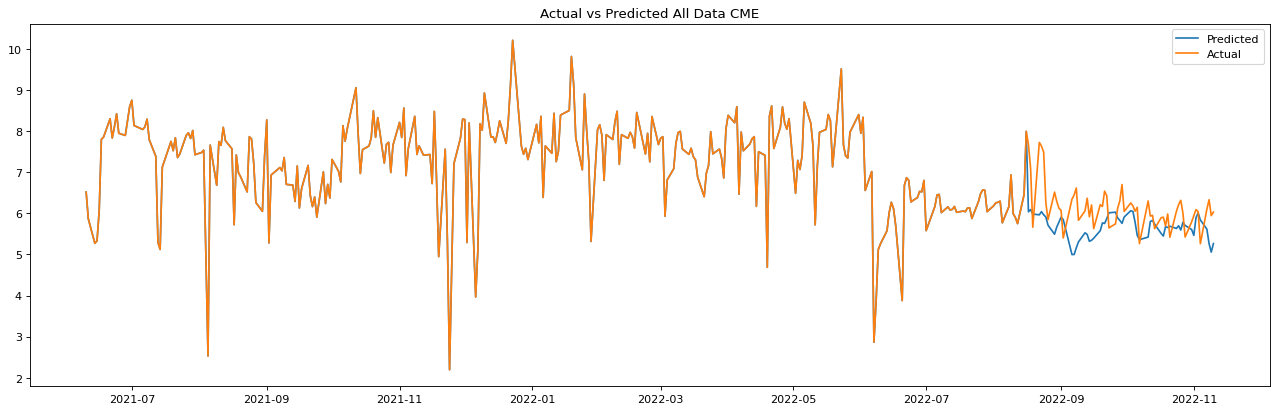

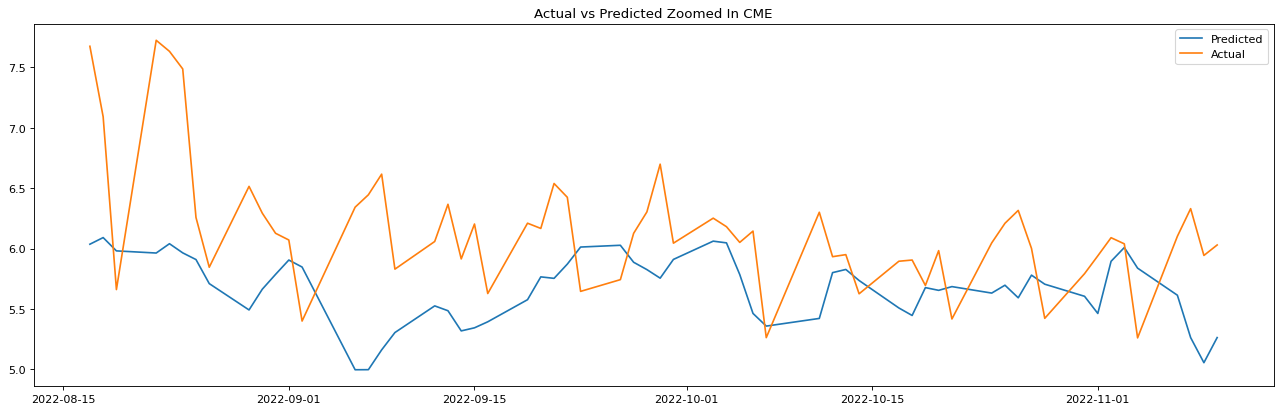

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphbk9qep0/8pwk94e1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphbk9qep0/v268qpyy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13540', 'data', 'file=/tmp/tmphbk9qep0/8pwk94e1.json', 'init=/tmp/tmphbk9qep0/v268qpyy.json', 'output', 'file=/tmp/tmphbk9qep0/prophet_modelx5cxn_ez/prophet_model-20230210123500.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:35:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:35:00 - cmdstanpy - INFO - Chain [1] don

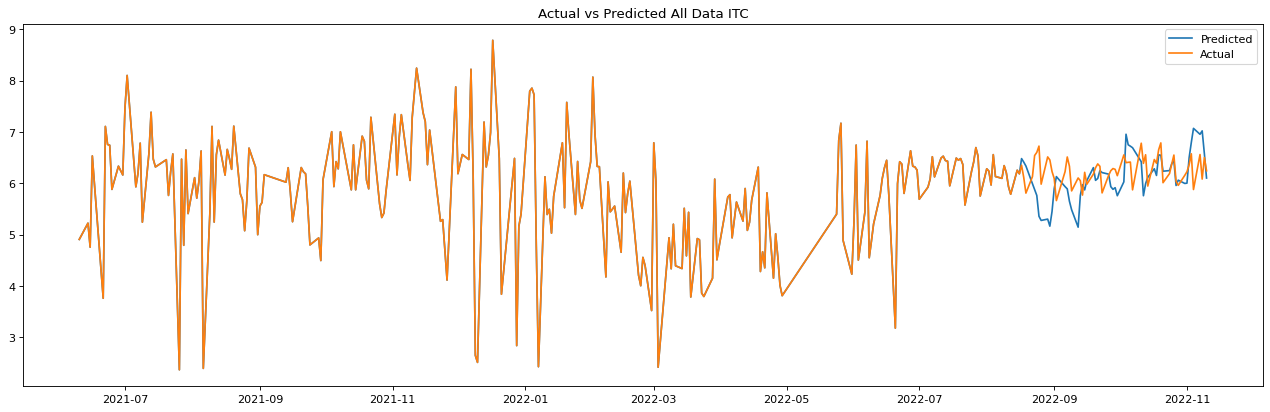

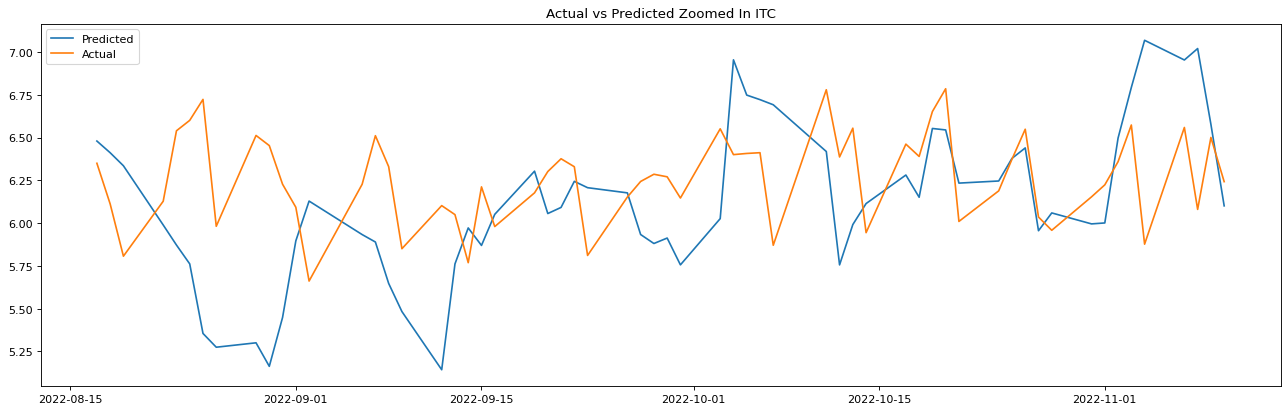

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphbk9qep0/f12xvexh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphbk9qep0/c8nccjq4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45827', 'data', 'file=/tmp/tmphbk9qep0/f12xvexh.json', 'init=/tmp/tmphbk9qep0/c8nccjq4.json', 'output', 'file=/tmp/tmphbk9qep0/prophet_modelioss1qxm/prophet_model-20230210123501.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:35:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:35:01 - cmdstanpy - INFO - Chain [1] don

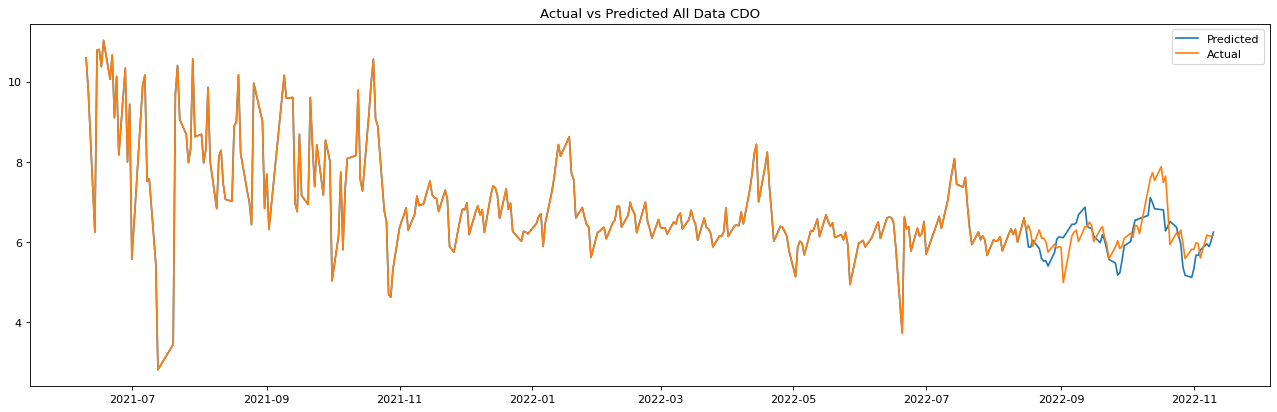

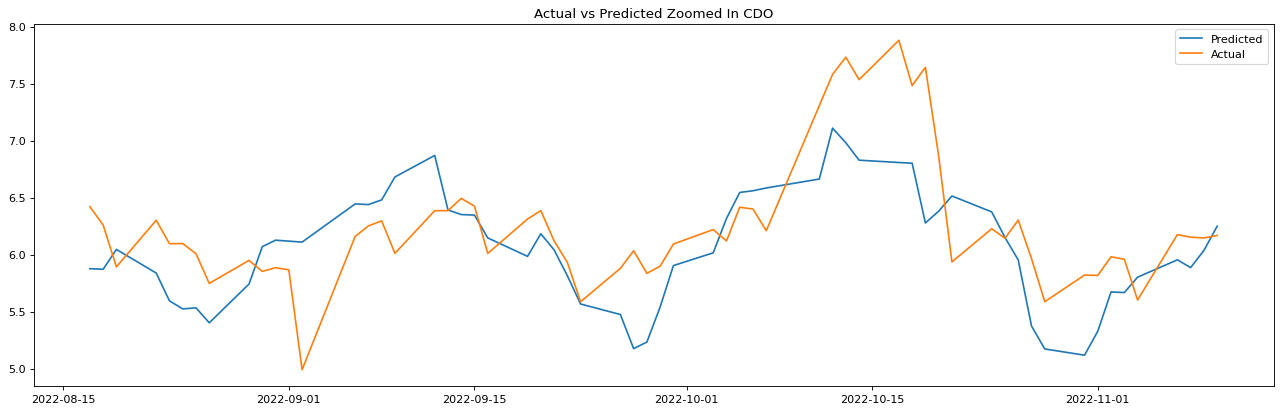

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphbk9qep0/8jyilo1e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphbk9qep0/r_a6ex3y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67580', 'data', 'file=/tmp/tmphbk9qep0/8jyilo1e.json', 'init=/tmp/tmphbk9qep0/r_a6ex3y.json', 'output', 'file=/tmp/tmphbk9qep0/prophet_modellnml_5xt/prophet_model-20230210123502.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:35:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:35:02 - cmdstanpy - INFO - Chain [1] don

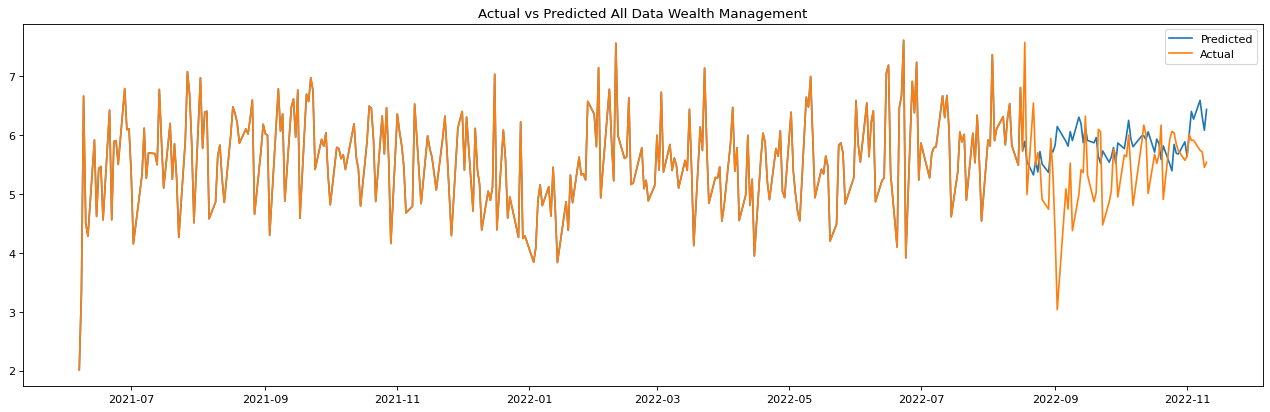

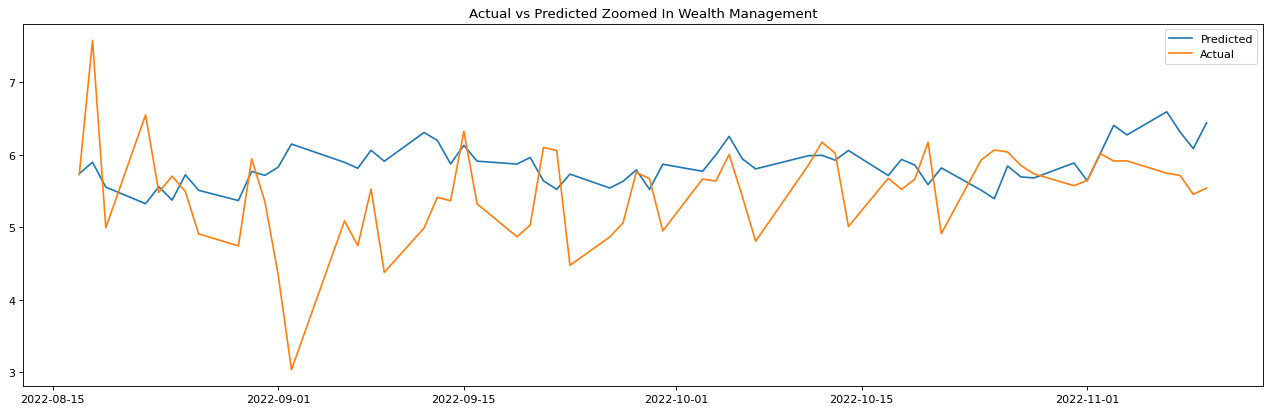

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphbk9qep0/o00x95tt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphbk9qep0/n9k80_fg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1548', 'data', 'file=/tmp/tmphbk9qep0/o00x95tt.json', 'init=/tmp/tmphbk9qep0/n9k80_fg.json', 'output', 'file=/tmp/tmphbk9qep0/prophet_modelfus98xjl/prophet_model-20230210123503.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:35:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:35:03 - cmdstanpy - INFO - Chain [1] done

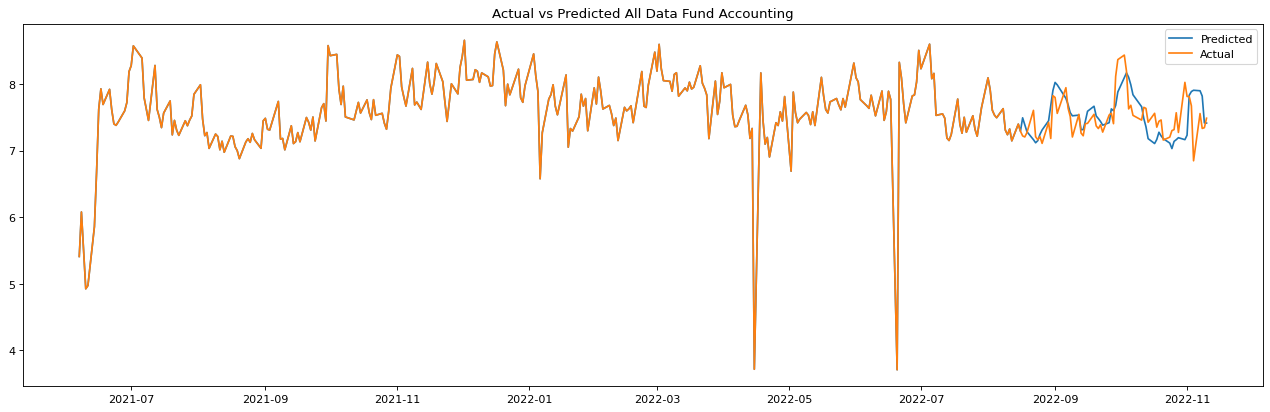

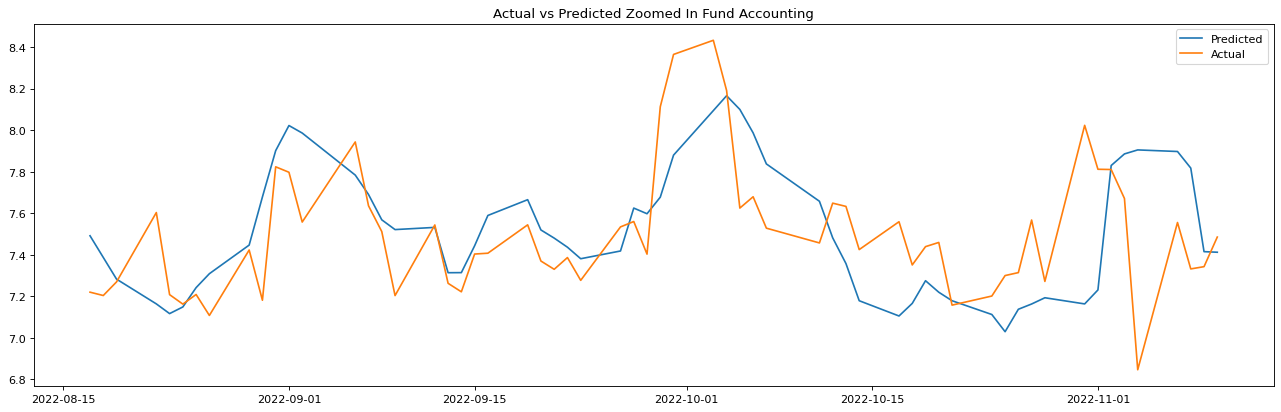

In [ ]:
# Run prophet
hols = give_hols(years)
num_forecast = forecast_days
prophet_error_log = []
prophet_prediction_result = []
for index, i in enumerate(dep):
  train, future, m = create_prophet(i[['ActivityDate','Utilization']], num_forecast, hols)
  forecast = m.predict(future)
  pred = get_prophet_prediction(i, forecast)
  prophet_prediction_result.append(pred)
  error_log = log_error_prophet(i, forecast)
  prophet_error_log.append(error_log)
  graph_whole_department_prophet(i, forecast, depname[index])
  graph_result_prophet(i, forecast, depname[index])
  

#### Graph error of new Prophet ####


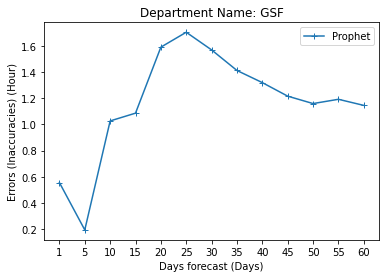

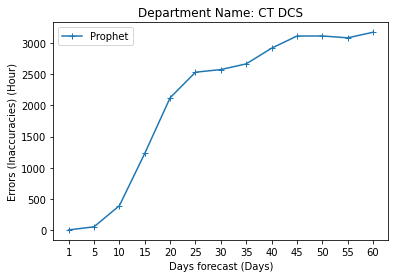

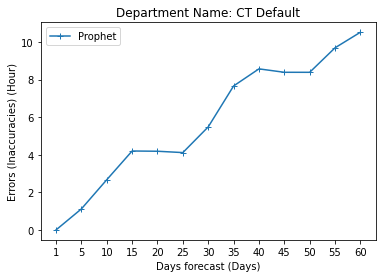

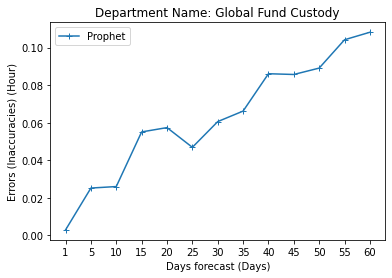

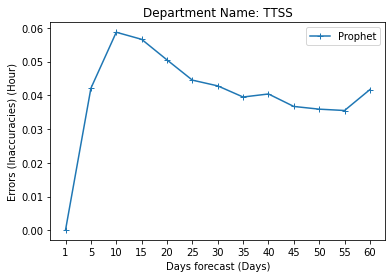

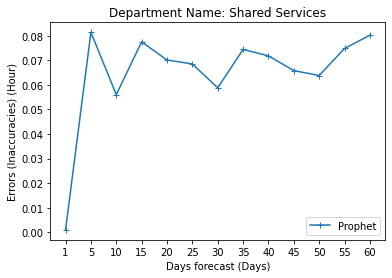

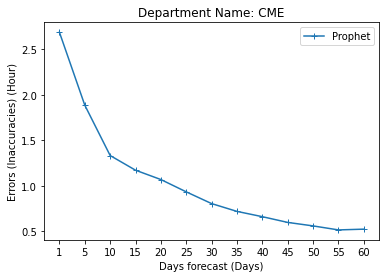

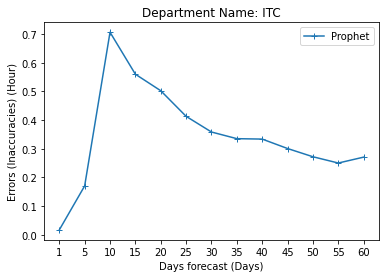

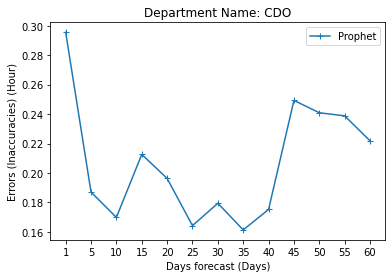

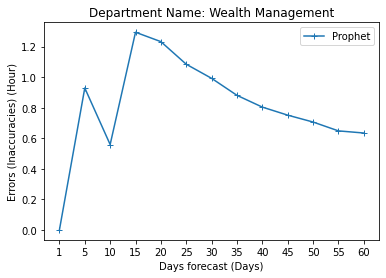

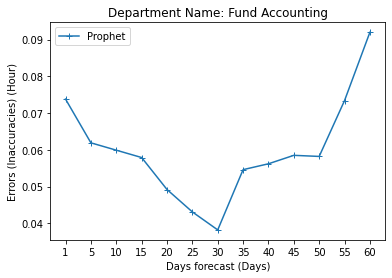

In [ ]:
from pylab import plot, show, title, xlabel, ylabel
from pylab import legend
from pylab import axis

def plotting_rest(models_error, models_name, depname, days_forecast, num_days_plot):
    #print("Plotting example 7............")
    days = []
    for i in range(1, num_days_plot+1):
      if i == 1 or i % 5 == 0:
        days.append(str(i))
    for index, name in enumerate(depname):
      for model_index, j in enumerate(models_error):
        plot(days, j[index][:len(days)], marker='+', label = models_name[model_index])
        # Plot the line WITH dots and the LINE
        #plot(days, UCM[index], months, Prophet[index], months, XGBoost[index],  months, RNN[index],  months, LSTM[index], marker='+')

        # Apply the legend to tell the graphs apart
        #legend(['UCM', 'Prophet', 'XGBoost', 'RNN', 'LSTM'])

        # Apply the TITLE, X-axis and Y-axis label
      title('Department Name: '+ name)
      xlabel('Days forecast (Days)')
      ylabel('Errors (Inaccuracies) (Hour)')
      legend()
      show()

#NOTE1: Joshua Reccomended adding Moving Average to the graph. I have not found a chance to do this. 

num_days_plot = forecast_days
models_name = ['Prophet']
models_error = [prophet_error_log]
plotting_rest(models_error, models_name, depname, forecast_days, num_days_plot)

### LSTM ###

Status: Error found in pred function. Still being used as for comparison for other models

In [ ]:
# # setting lstm sequence length
# time_steps = 50

# # train test set splitting 
# def train_test_lstm(df):
#   data_set = df.loc[:, ["Utilization"]].values
#   train = data_set[:len(data_set) - forecast_days]
#   test = data_set[len(train):]

#   train.reshape(train.shape[0],1)
#   return train, test

# # Normalization with MinmaxScaler
# def Normalize(train):
#     scaler = MinMaxScaler(feature_range = (0,1)) 
#     train_scaler = scaler.fit_transform(train)
#     return train_scaler

# # create training sequences - length time_steps
# def train_testlstm (train_scaler):
#     X_train = []
#     Y_train = []
#     timesteps = time_steps
#     #Fixed the loop to extend output length from 1 to 50 (forecast_days)
#     for i in range(timesteps, len(train_scaler)):
#         X_train.append(train_scaler[i - timesteps:i, 0])
#         # HERE, Prediction is 1 day ahead 
#         Y_train.append(train_scaler[i,0]) 
#         # Attempt to fix the output size
#         # Y_train.append(train_scaler[i:i+forecast_days,0]) 
#     X_train, Y_train = np.array(X_train), np.array(Y_train)

#     #reshape
#     #print(X_train.shape)
#     X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) 
#     trainX = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))

#     return X_train, Y_train, trainX

# # LSTM model - 1 LSTM layer, 1 dense layer, mse loss
# def lstmmodel(trainX, Y_train):
#   timesteps = time_steps
#   model = Sequential()
#   model.add(LSTM(10, input_shape = (1, timesteps)))
#   model.add(Dense(1))
#   model.compile(loss = "mean_squared_error", optimizer = "adam")
#   model.fit(trainX, Y_train, epochs = 100, batch_size = 1, verbose = 0)
#   return model

# def pred (df, model):
#     # Prepare test dataset
#     #### ERROR ROOT #### This input includes test data. Would be fine if we excluded it when we call our model but we didn't, more details below 
#     data_set = df.loc[:, ["Utilization"]].values
#     timesteps = time_steps

#     #### FOUND ERROR HERE #### 
#     # With this input length, the sequences were generated incorrectly. LSTM predicts the last len(test) days in the input set instead of predicting the future.
#     inputs = data_set[len(data_set) - len(test) - timesteps:]
#     # Attempt to fixed the input length
#     # inputs = data_set[len(data_set) - timesteps:]

#     # Rescaling data 
#     scaler = MinMaxScaler(feature_range = (0,1))
#     #train_scaler = scaler.fit_transform(inputs)
#     inputs = scaler.fit_transform(inputs)

#   # Generate Predictions
#     # Create sequences 
#     X_test = []
#     for i in range(timesteps, inputs.shape[0]):
#       #### ERROR EXTENDED #### 
#       # With the wrong input length, 50 (days to forecast) sequences length 50 (timesteps) were created to predict 50 days ahead. But in reality, the predicted 50 days are the last 50 days in the input
#       # Each sequence only predicts 1 day ahead. And our sequences contain test data.   
#        X_test.append(inputs[i - timesteps:i, 0])
#       # Attempt to Fix the sequence creation
#     #X_test = inputs
#     testX = np.array(X_test)
#     testX = testX.reshape(testX.shape[0], 1, testX.shape[1])

#     # Predict with testX
#     predict_lstm = model.predict(testX)
#     predict_lstm = scaler.inverse_transform(predict_lstm)
#     return predict_lstm

# def ploting (predicted_Utilization, test, depname):
#   # visualising the results
#     plt.plot(test, color = "red", label = "Utilization")
#     plt.plot(predicted_Utilization, color = "blue", label = "Predicted Utilization")
#     plt.title("Utilization Prediction " + depname)
#     plt.xlabel("Time")
#     plt.ylabel("Utilization")
#     plt.legend()
#     plt.show()

# def eval(y_test, test_predictions_summary):
#   error_log = []
#   for i in range(1, forecast_days + 1):
#     if i == 1:
#       error_log.append(round(mean_squared_error(y_test[:1], test_predictions_summary[:1]),4))
#     elif i % 5 == 0:
#       error_log.append(round(mean_squared_error(y_test[:i], test_predictions_summary[:i]),4))
#   return error_log  

In [ ]:
# lstm_error_log = []
# for index, i in enumerate(dep):
#   train, test = train_test_lstm(i[['ActivityDate','Utilization']])
#   train_scaler = Normalize(train)
#   X_train, Y_train, trainX = train_testlstm(train_scaler)
#   model = lstmmodel(trainX, Y_train)
#   predicted = pred(i[['ActivityDate','Utilization']], model)
#   mse = mean_squared_error(test, predicted, squared=False)
#   ploting(predicted, test, depname[index])
#   error_log = eval(test, predicted)
#   lstm_error_log.append(error_log)

# print(lstm_error_log)

### UCM ###

In [ ]:
from statsmodels.tsa.statespace.structural import UnobservedComponents

def train_test_split(df, graph):
  
  n = df.shape[0]

  train_test_ratio = 1 - (forecast_days/n) # getting forecast_days days predictions
  n_train = int(n * train_test_ratio)
  n_test = n - n_train

  data_train_df = df[: n_train]
  data_test_df = df[- n_test :]

  y_train = data_train_df["Utilization"]

  y_test = data_test_df["Utilization"]
  if graph:
    sns_c = sns.color_palette(palette="deep")
    fig, ax = plt.subplots()
    sns.lineplot(x=y_train.index, y=y_train, marker="o", markersize=5, color=sns_c[0], label="y_train", ax=ax)
    sns.lineplot(x=y_test.index, y=y_test, marker="o", markersize=5, color=sns_c[1], label="y_test", ax=ax)
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set(title="Train-Test Split")
  
  return y_train, y_test

def train_UCM(df,department_name, freq_seasonal, plot_components = False, graph = True):
  y_train, y_test = train_test_split(df, graph)
  model_params =  {
    "endog": y_train,
    "level": "local level",
    "freq_seasonal": freq_seasonal,
    "autoregressive": 1,
    "mle_regression": True,
 } ### How do we automate this parameter choice ###

  ## https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.structural.UnobservedComponents.html ##
  model = UnobservedComponents(**model_params)
  results = model.fit(disp=0) # fit UCM to our data 

  if plot_components:
    fig = results.plot_components(figsize=(12, 9), alpha=0.1)

    for ax in fig.get_axes():
        ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
        ax.set(title=None)

    fig.suptitle("Model Components", y=0.92);

  # After fitting, we want predictions #
  test_predictions_summary = results.get_forecast(steps=y_test.shape[0]).summary_frame(alpha=0.1) 
  # change the significance level of the confidence interval and prediction interval by modifying the "alpha" parameter 
  test_predictions_summary.index = y_test.index

  error_log = []
  for i in range(1, forecast_days + 1):
    if i == 1:
      error_log.append(round(mean_squared_error(y_test[:i], test_predictions_summary["mean"][:i]),4))
    elif i % 5 == 0:
      error_log.append(round(mean_squared_error(y_test[:i], test_predictions_summary["mean"][:i]),4))
  #print(error_log)

  return y_test, y_train, test_predictions_summary, error_log

def get_UCM_prediction(df, test_predictions_summary):
  predictions = pd.DataFrame()
  predictions['ActivityDate'] = df['ActivityDate'][-forecast_days:]
  predictions['Utilization'] = test_predictions_summary['mean']
  return predictions

def graph_result(y_test, y_train, test_predictions_summary, depname):
  fig, ax = plt.subplots()
  sns.lineplot(
      x=y_test.index,
      y=y_test,
      marker="o",
      markersize=5,
      color="C1",
      label="y_test",
      ax=ax
  )
  sns.lineplot(
      x=test_predictions_summary.index,
      y=test_predictions_summary["mean"],
      marker="o",
      markersize=5,
      color="C3",
      label="y_test_pred",
      ax=ax
  )
  ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
  ax.set(title="Unobserved Components Model Predictions " + depname)


/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimiz

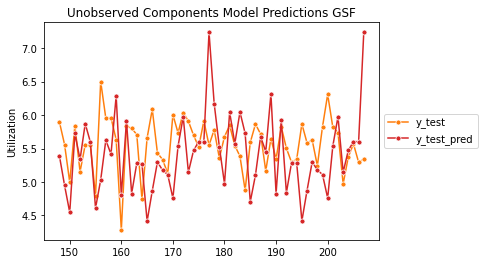

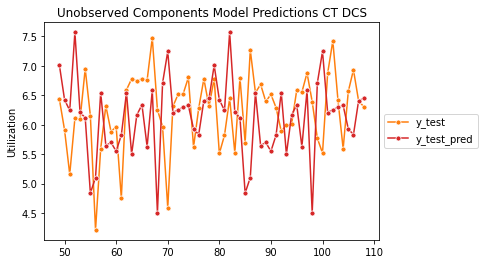

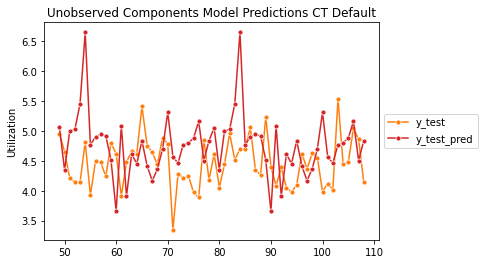

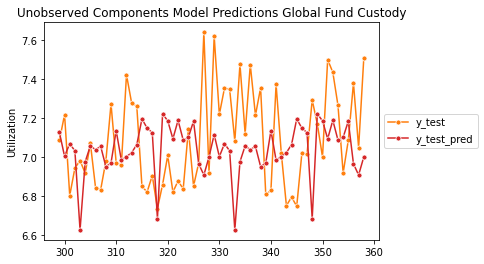

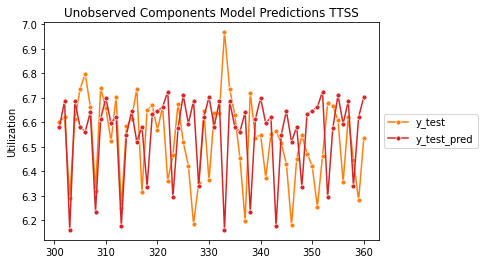

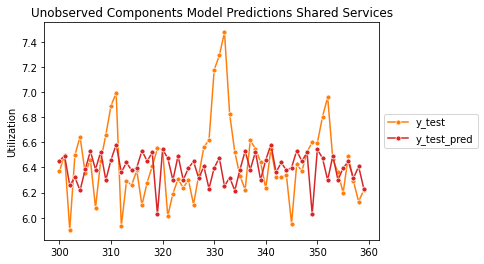

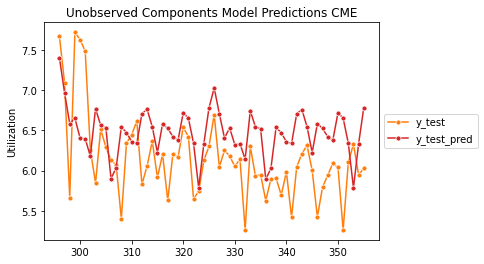

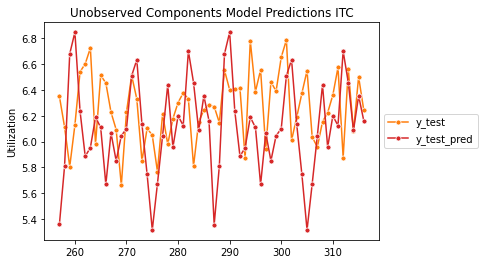

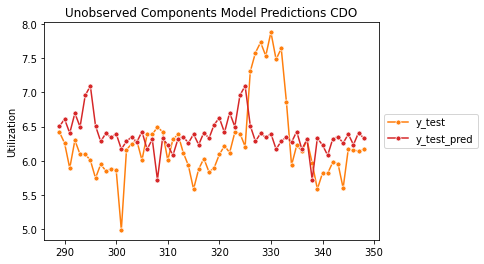

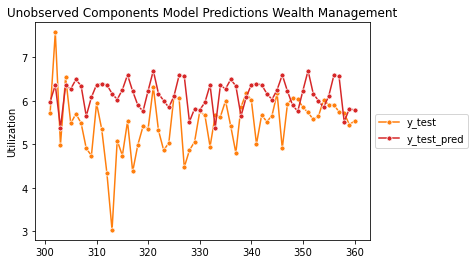

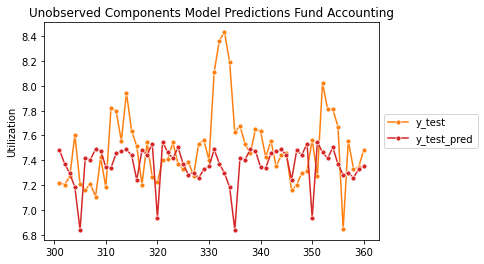

In [ ]:
## Running UCM for all departments, log the error, and graph pred vs real
dep_freq_seasonal = [{'period': 10},{'period': 30}, {'period': 5}]
UCM_error_log = []
UCM_prediction_result = []
for index, i in enumerate(dep):
  y_test, y_train, test_predictions_summary, error_log = train_UCM(i,depname[index], dep_freq_seasonal, graph = False)
  UCM_error_log.append(error_log)
  prediction = get_UCM_prediction(i, test_predictions_summary)
  UCM_prediction_result.append(prediction)
  graph_result(y_test, y_train, test_predictions_summary, depname[index])

### Improve Manual UCM ###

In [ ]:
# Manual
freq_dict = {}
freq_dict['CDO'] = [{'period': 65}]
freq_dict['CME'] = [{'period': 5}]
freq_dict['CT DCS'] = [{'period': 5}]
freq_dict['CT Default'] = [{'period': 21}]
freq_dict['Fund Accounting'] = [{'period': 5}, {'period': 10}]
freq_dict['GSF'] = [{'period': 5}]
freq_dict['Global Fund Custody'] = [{'period': 5}, {'period': 25}]
freq_dict['ITC'] = [{'period': 5},{'period': 10}]
freq_dict['Shared Services'] = [{'period': 5},{'period': 65}]
freq_dict['TTSS'] = [{'period': 5},{'period': 65}]
freq_dict['Wealth Management'] = [{'period': 5}]

/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


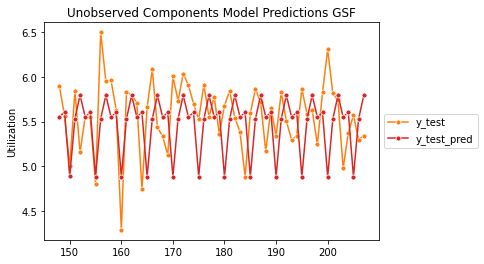

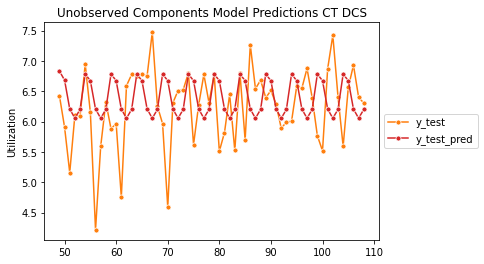

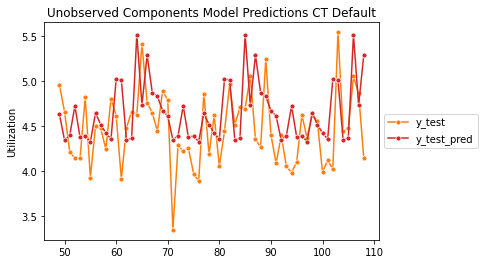

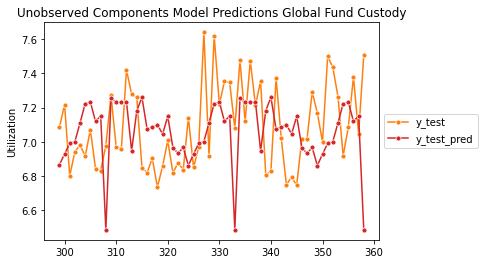

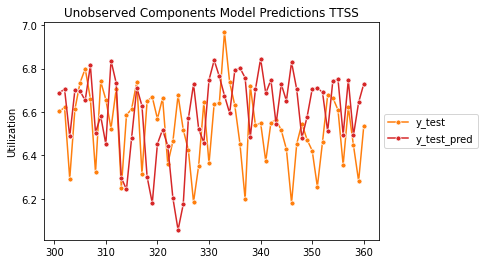

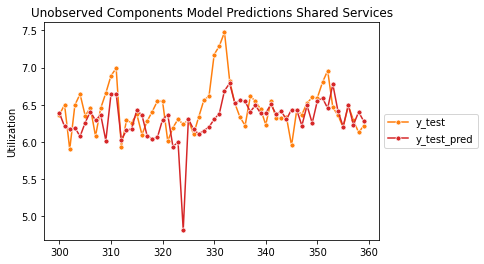

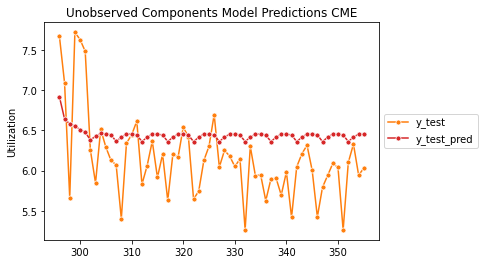

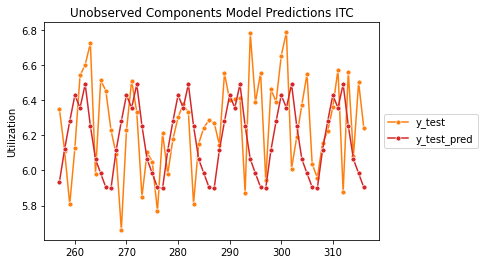

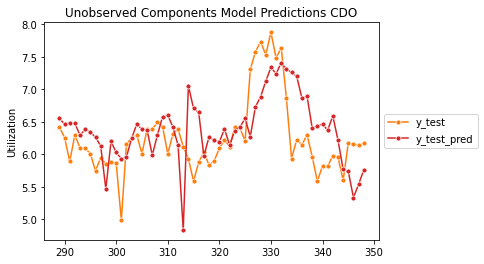

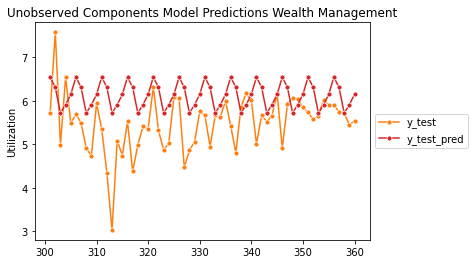

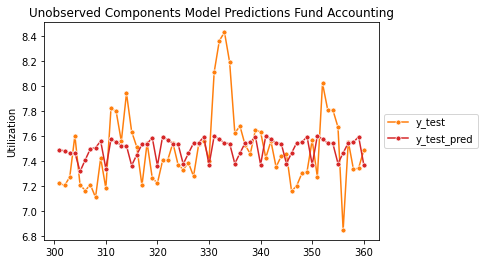

In [ ]:
Manual_UCM_error_log = []
UCM_prediction_result = []
for index, i in enumerate(dep):
  y_test, y_train, test_predictions_summary, error_log = train_UCM(i,depname[index], freq_dict[depname[index]], graph = False)
  Manual_UCM_error_log.append(error_log)
  prediction = get_UCM_prediction(i, test_predictions_summary)
  UCM_prediction_result.append(prediction)
  graph_result(y_test, y_train, test_predictions_summary, depname[index])

### AUTOMATING UCM ###

In [ ]:
from astropy.timeseries import LombScargle

def get_period_peaks_2(d):
  df1 = d
  df1 = df1.set_index('ActivityDate')
  # Extract the time series data
  times = df1.index
  utili = df1['Utilization']

  times = (times - times[0]).days

  # get lomb scargle freq and pow
  frequency, power = LombScargle(np.linspace(0,len(times),len(times)), utili).autopower()
  period = 1/frequency

  # Put our power and period into a df to process
  newDF = pd.DataFrame()
  newDF['period'] = period
  newDF['power'] = power
  newDF = newDF[(newDF['period'] > 2) & (newDF['period'] < 75)].reset_index().drop(columns = ['index'])

  # Find our peaks here
  newDF['max_peaks'] = newDF['power'][(newDF['power'].shift(1) < newDF['power']) & (newDF['power'].shift(-1) < newDF['power'])]

  # Get the 3 largest peaks
  peaks = newDF.nlargest(3, 'max_peaks')
  freq_dict_el = [round(x) for x in list(peaks['period'])]

  # Modify here, return only the largest peaks
  # freq_dict = [{'period': freq_dict_el[0]}, {'period': freq_dict_el[1]}, {'period': freq_dict_el[2]}]
  freq_dict = [{'period': freq_dict_el[0]}]
  return freq_dict

for index, dept in enumerate(dep):
  print(depname[index], get_period_peaks_2(dept))

GSF [{'period': 17}]
CT DCS [{'period': 5}]
CT Default [{'period': 22}]
Global Fund Custody [{'period': 54}]
TTSS [{'period': 36}]
Shared Services [{'period': 21}]
CME [{'period': 70}]
ITC [{'period': 9}]
CDO [{'period': 21}]
Wealth Management [{'period': 5}]
Fund Accounting [{'period': 21}]


/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


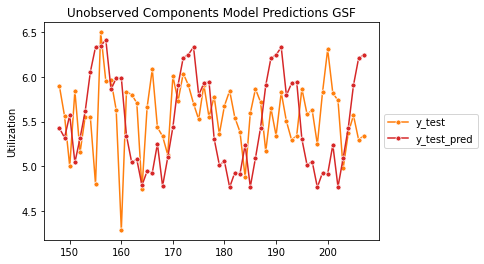

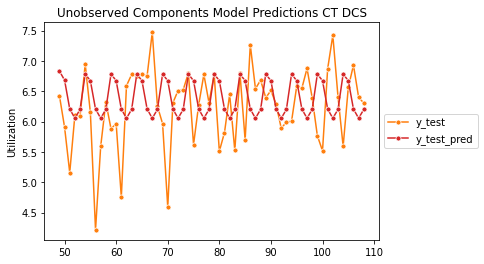

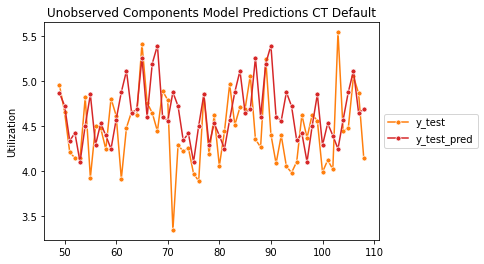

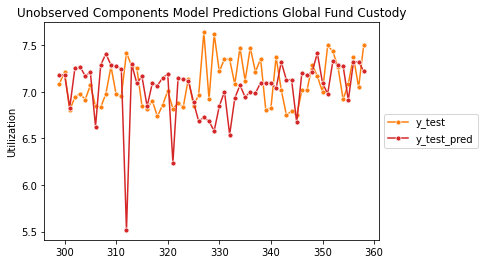

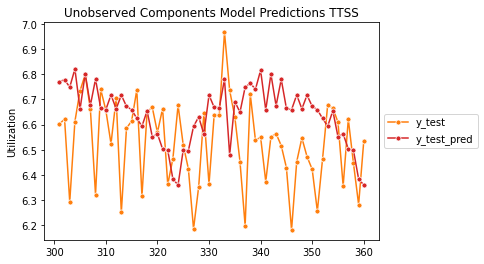

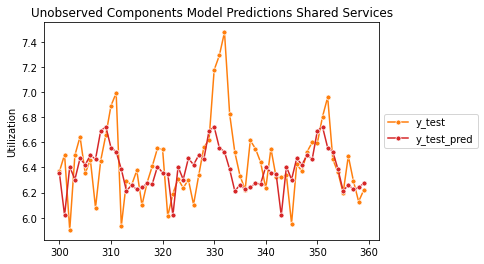

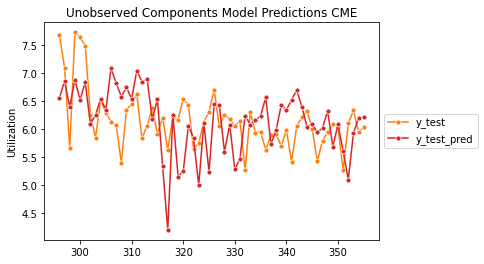

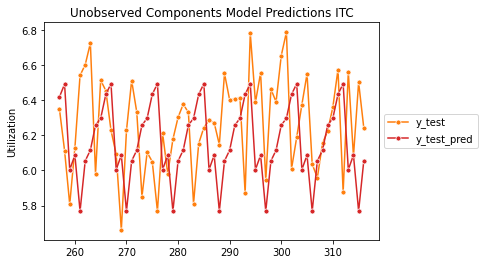

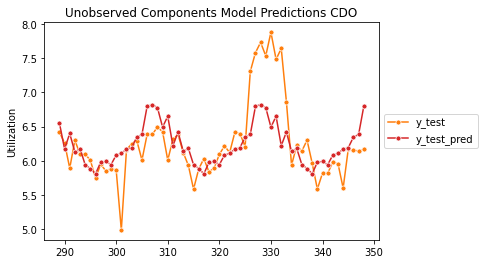

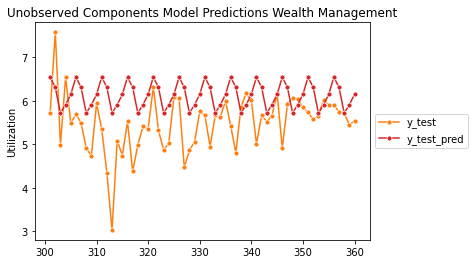

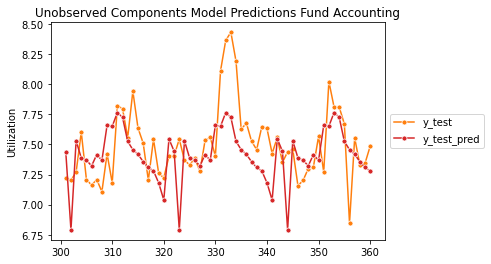

In [ ]:
Auto_UCM_error_log = []
UCM_prediction_result = []
for index, i in enumerate(dep):
  y_test, y_train, test_predictions_summary, error_log = train_UCM(i,depname[index], get_period_peaks_2(i), graph = False)
  Auto_UCM_error_log.append(error_log)
  prediction = get_UCM_prediction(i, test_predictions_summary)
  UCM_prediction_result.append(prediction)
  graph_result(y_test, y_train, test_predictions_summary, depname[index])

### Graphing errors ###

In [ ]:
#NOTE1: Joshua Reccomended adding Moving Average to the graph. I have not found a chance to do this. 
#NOTE2: LSTM is being used as a comparison, not as a main model, due to error. LSTM performance can represnet Moving Average Performance
# num_days_plot = 50
# models_name = ['Prophet','Ideal Model', 'UCM']
# models_error = [prophet_error_log, lstm_error_log, UCM_error_log]
# plotting_rest(models_error, models_name, depname, forecast_days, num_days_plot)

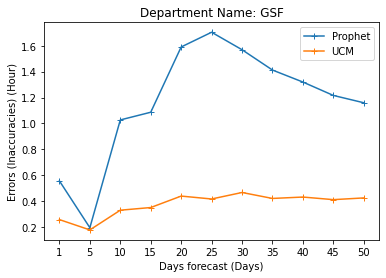

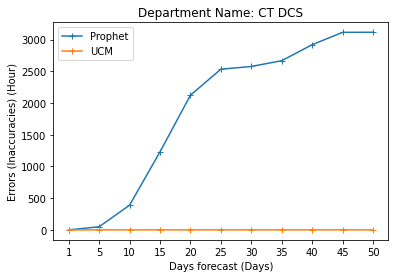

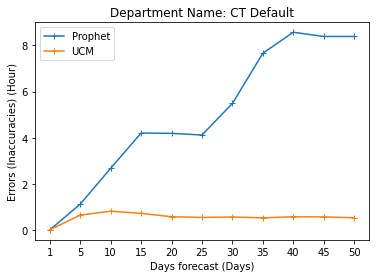

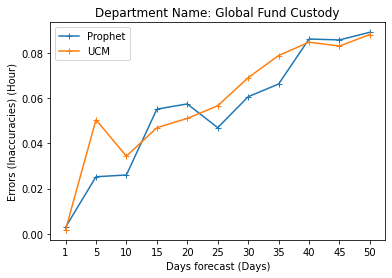

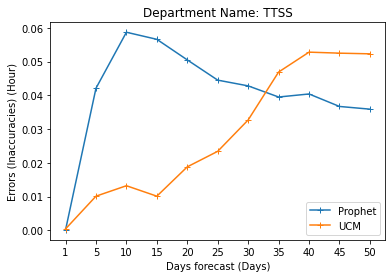

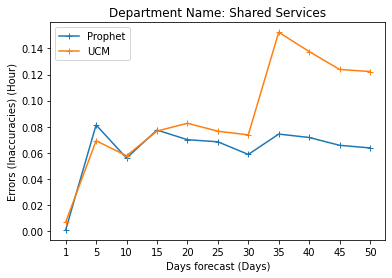

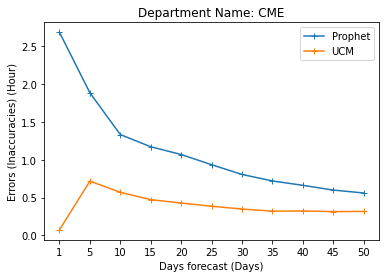

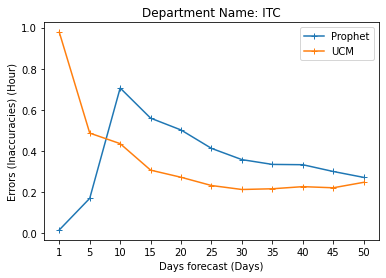

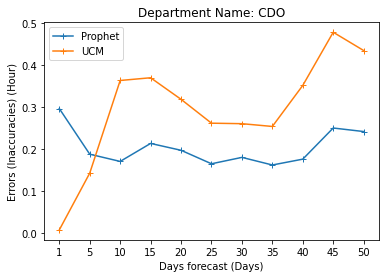

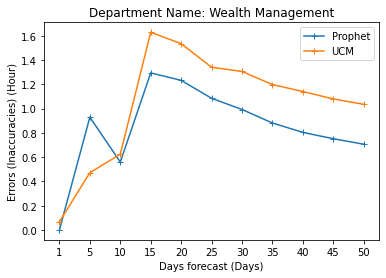

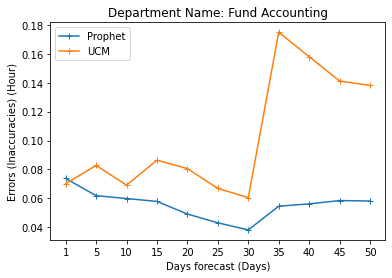

In [ ]:
num_days_plot = 50
models_name = ['Prophet', 'UCM']
models_error = [prophet_error_log, UCM_error_log]
plotting_rest(models_error, models_name, depname, forecast_days, num_days_plot)

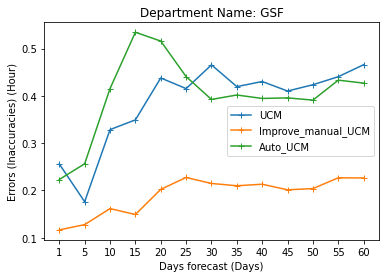

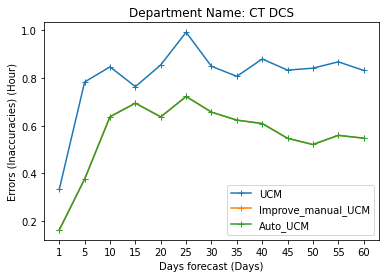

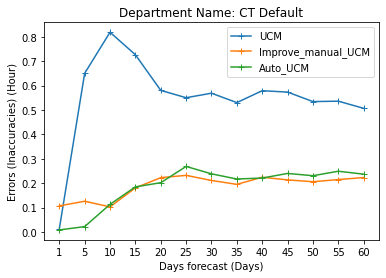

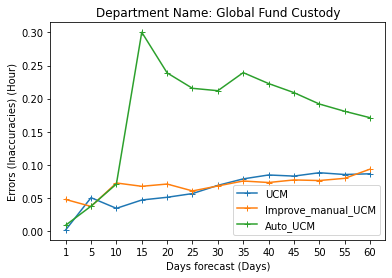

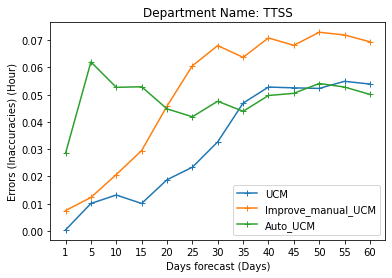

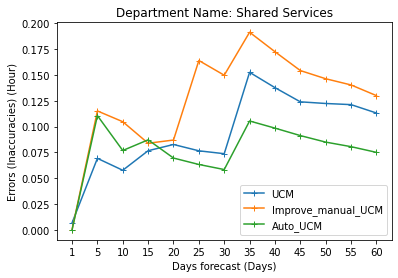

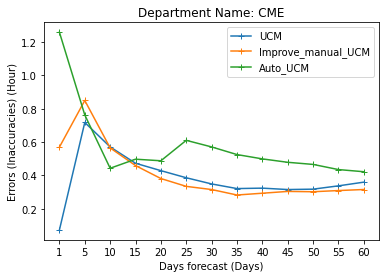

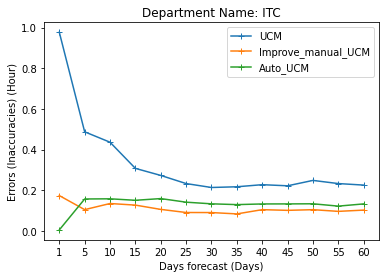

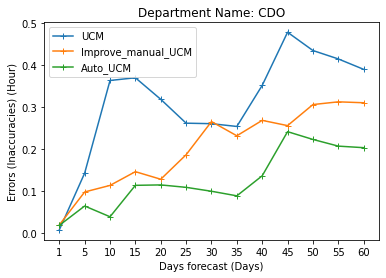

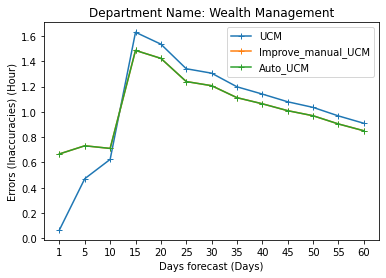

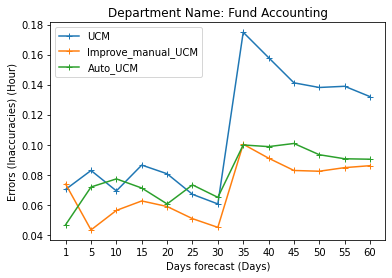

In [ ]:
num_days_plot = 60
models_name = ['UCM', 'Improve_manual_UCM', 'Auto_UCM']
models_error = [UCM_error_log, Manual_UCM_error_log, Auto_UCM_error_log]
plotting_rest(models_error, models_name, depname, forecast_days, num_days_plot)

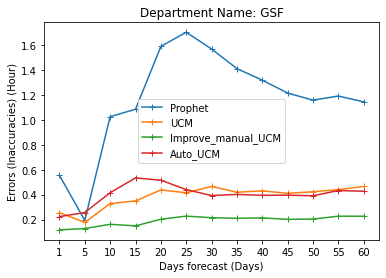

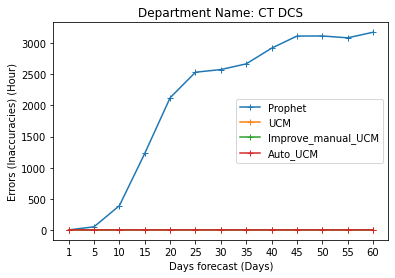

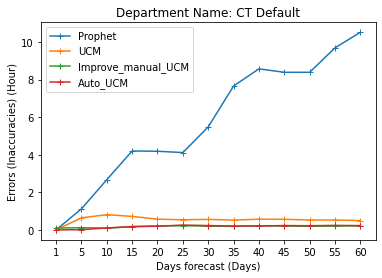

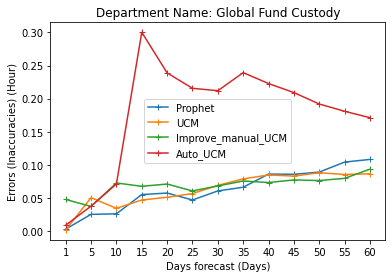

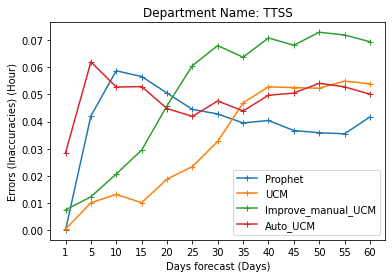

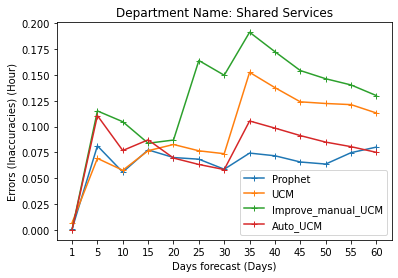

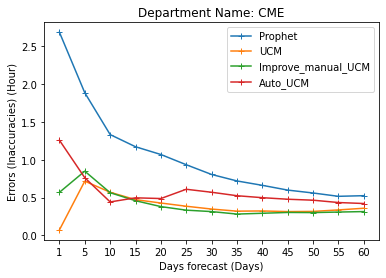

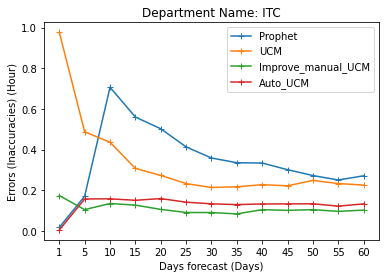

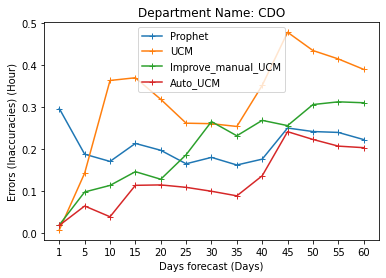

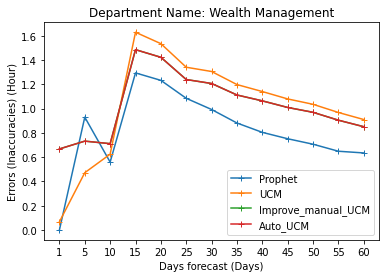

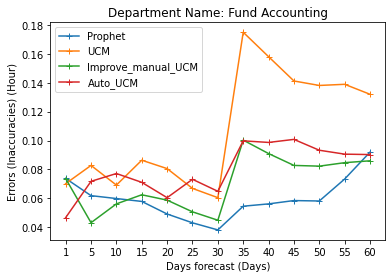

In [ ]:
num_days_plot = 60
models_name = ['Prophet', 'UCM', 'Improve_manual_UCM', 'Auto_UCM']
models_error = [prophet_error_log, UCM_error_log, Manual_UCM_error_log, Auto_UCM_error_log]
plotting_rest(models_error, models_name, depname, forecast_days, num_days_plot)

### Demo Results ###

In [ ]:
# DataFrame dep: dataframe, must have 2 columns ActivityDate and Utilization, must have the date being used
# int num_employees: number of employees in the department
# int totalhours: number of hours need to complete the task
# String startdate: date to start YYYY-MM-DD
# return number of business days needed for the task and the end date
def capacityPlanning(dep, num_employees, totalhours, startdate):
  start = dep.loc[dep['ActivityDate'] == startdate]
  if len(start) == 0:
    return 0, 'Date input Do Not Exist in the given data'
  else:
    hours_done = 0
    for i in range(start.index[0], dep.shape[0]):
      hours_done += dep.iloc[i]['Utilization']*num_employees
      if hours_done > totalhours:
        return i-start.index[0], 'End Date: ' + str(dep.iloc[i]['ActivityDate'])[:10]
  return -1, 'Can not be completed within the given dates in the data'

# Get department data from dataframe
def getDep(df, depName):
  dep = df[df.index.get_level_values(0)==depName]
  dep = dep.droplevel(level=0).reset_index()
  dep = dep[['ActivityDate', 'Utilization']]
  return dep

def demo_run(dep, dep_predicted):
  startdate = str(prediction['ActivityDate'].iloc[0])[:10]
  total_cases = 0
  correct_cases = [0,0,0,0,0,0,0,0,0,0,0]
  for num_employees in tqdm(range(1, 10000, 5)):
    for totalhours in range(10, 100000, 200):
      days_actual, endDate_actual = capacityPlanning(dep, num_employees, totalhours, startdate)
      days_predicted, endDate_predicted = capacityPlanning(dep_predicted, num_employees, totalhours, startdate)
      #print(days_actual, days_predicted)
      total_cases +=1
      errors = abs(days_actual - days_predicted) 
      if errors < 11:
        for idx in range(errors, 11):
          correct_cases[idx] += 1
  #print(correct_cases)
  #print(total_cases)
  return [correct/total_cases for correct in correct_cases]

In [ ]:
from tqdm import tqdm
capacity_accuracy = []
for index, i in enumerate(dep):
  if (depname[index] == 'CT Default') or (depname[index] == 'CT DCS'):
    dep_predicted = UCM_prediction_result[index]
  else:
    dep_predicted = prophet_prediction_result[index]
  dep_predicted = dep_predicted.reset_index()
  #print(dep_predicted)
  #print(i)
  accuracy = demo_run(i, dep_predicted)
  print(depname[index])
  print(accuracy)
  capacity_accuracy.append(accuracy)

capacity_accuracy

# OUTPUT1: 
# Num Employee 1 -> 10000, step 5. Total Hours 10 -> 100000, step 20000. (10000 cases)
# [0.7747, 0.9134, 0.9437, 0.9797, 0.9989, 0.9989, 0.9989, 0.9989, 0.9989, 0.9989, 0.9989] 
# [0.8558, 0.9913, 0.9991, 0.9994, 0.9994, 0.9994, 0.9994, 0.9994, 0.9994, 0.9994, 0.9994]
# [0.777, 0.9998, 0.9998, 0.9998, 0.9998, 0.9998, 0.9998, 0.9998, 0.9998, 0.9998, 0.9998]
# [0.9336, 0.9981, 0.9996, 0.9996, 0.9996, 0.9996, 0.9996, 0.9996, 0.9996, 0.9996, 0.9996]
# [0.9787, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999]
# [0.9657, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
# [0.8968, 0.9998, 0.9998, 0.9998, 0.9998, 0.9998, 0.9998, 0.9998, 0.9998, 0.9998, 0.9998]
# [0.9396, 0.9994, 0.9996, 0.9996, 0.9996, 0.9996, 0.9996, 0.9996, 0.9996, 0.9996, 0.9996]
# [0.8942, 0.9993, 0.9998, 0.9998, 0.9998, 0.9998, 0.9998, 0.9998, 0.9998, 0.9998, 0.9998]
# [0.6208, 0.8875, 0.9646, 0.9947, 0.9988, 0.9988, 0.9988, 0.9988, 0.9988, 0.9988, 0.9988]
# [0.9823, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
# OUTPUT2: Num Employee 1 -> 10000, step 5. Total Hours 10 -> 100000, step 200. (1 000 000 cases)
# 100%|██████████| 2000/2000 [49:38<00:00,  1.49s/it]
# GSF
# [0.71732, 0.891773, 0.930074, 0.974835, 0.998644, 0.998644, 0.998644, 0.998644, 0.998644, 0.998644, 0.998644]
# 100%|██████████| 2000/2000 [46:33<00:00,  1.40s/it]
# CT DCS
# [0.818762, 0.988854, 0.99891, 0.99925, 0.99925, 0.99925, 0.99925, 0.99925, 0.99925, 0.99925, 0.99925]
# 100%|██████████| 2000/2000 [50:31<00:00,  1.52s/it]
# CT Default
# [0.764803, 0.999691, 0.999691, 0.999691, 0.999691, 0.999691, 0.999691, 0.999691, 0.999691, 0.999691, 0.999691]
# 100%|██████████| 2000/2000 [44:12<00:00,  1.33s/it]
# Global Fund Custody
# [0.919725, 0.997666, 0.999487, 0.999487, 0.999487, 0.999487, 0.999487, 0.999487, 0.999487, 0.999487, 0.999487]
# 100%|██████████| 2000/2000 [46:13<00:00,  1.39s/it]
# TTSS
# [0.974888, 0.999794, 0.999794, 0.999794, 0.999794, 0.999794, 0.999794, 0.999794, 0.999794, 0.999794, 0.999794]
# 100%|██████████| 2000/2000 [44:32<00:00,  1.34s/it]
# Shared Services
# [0.960242, 0.999992, 0.999992, 0.999992, 0.999992, 0.999992, 0.999992, 0.999992, 0.999992, 0.999992, 0.999992]
# 100%|██████████| 2000/2000 [46:22<00:00,  1.39s/it]
# CME
# [0.872516, 0.999737, 0.999737, 0.999737, 0.999737, 0.999737, 0.999737, 0.999737, 0.999737, 0.999737, 0.999737]
# 100%|██████████| 2000/2000 [46:37<00:00,  1.40s/it]
# ITC
# [0.930077, 0.999473, 0.999591, 0.999591, 0.999591, 0.999591, 0.999591, 0.999591, 0.999591, 0.999591, 0.999591]
# 100%|██████████| 2000/2000 [45:32<00:00,  1.37s/it]
# CDO
# [0.869035, 0.999138, 0.9996, 0.9996, 0.9996, 0.9996, 0.9996, 0.9996, 0.9996, 0.9996, 0.9996]
# 100%|██████████| 2000/2000 [48:07<00:00,  1.44s/it]
# Wealth Management
# [0.527436, 0.859683, 0.956474, 0.993279, 0.998545, 0.998545, 0.998545, 0.998545, 0.998545, 0.998545, 0.998545]
# 100%|██████████| 2000/2000 [42:48<00:00,  1.28s/it]Fund Accounting
# [0.97825, 0.999931, 0.999931, 0.999931, 0.999931, 0.999931, 0.999931, 0.999931, 0.999931, 0.999931, 0.999931]

100%|██████████| 2000/2000 [49:38<00:00,  1.49s/it]


GSF
[0.71732, 0.891773, 0.930074, 0.974835, 0.998644, 0.998644, 0.998644, 0.998644, 0.998644, 0.998644, 0.998644]


100%|██████████| 2000/2000 [46:33<00:00,  1.40s/it]


CT DCS
[0.818762, 0.988854, 0.99891, 0.99925, 0.99925, 0.99925, 0.99925, 0.99925, 0.99925, 0.99925, 0.99925]


100%|██████████| 2000/2000 [50:31<00:00,  1.52s/it]


CT Default
[0.764803, 0.999691, 0.999691, 0.999691, 0.999691, 0.999691, 0.999691, 0.999691, 0.999691, 0.999691, 0.999691]


100%|██████████| 2000/2000 [44:12<00:00,  1.33s/it]


Global Fund Custody
[0.919725, 0.997666, 0.999487, 0.999487, 0.999487, 0.999487, 0.999487, 0.999487, 0.999487, 0.999487, 0.999487]


100%|██████████| 2000/2000 [46:13<00:00,  1.39s/it]


TTSS
[0.974888, 0.999794, 0.999794, 0.999794, 0.999794, 0.999794, 0.999794, 0.999794, 0.999794, 0.999794, 0.999794]


100%|██████████| 2000/2000 [44:32<00:00,  1.34s/it]


Shared Services
[0.960242, 0.999992, 0.999992, 0.999992, 0.999992, 0.999992, 0.999992, 0.999992, 0.999992, 0.999992, 0.999992]


100%|██████████| 2000/2000 [46:22<00:00,  1.39s/it]


CME
[0.872516, 0.999737, 0.999737, 0.999737, 0.999737, 0.999737, 0.999737, 0.999737, 0.999737, 0.999737, 0.999737]


100%|██████████| 2000/2000 [46:37<00:00,  1.40s/it]


ITC
[0.930077, 0.999473, 0.999591, 0.999591, 0.999591, 0.999591, 0.999591, 0.999591, 0.999591, 0.999591, 0.999591]


100%|██████████| 2000/2000 [45:32<00:00,  1.37s/it]


CDO
[0.869035, 0.999138, 0.9996, 0.9996, 0.9996, 0.9996, 0.9996, 0.9996, 0.9996, 0.9996, 0.9996]


100%|██████████| 2000/2000 [48:07<00:00,  1.44s/it]


Wealth Management
[0.527436, 0.859683, 0.956474, 0.993279, 0.998545, 0.998545, 0.998545, 0.998545, 0.998545, 0.998545, 0.998545]


100%|██████████| 2000/2000 [42:48<00:00,  1.28s/it]

Fund Accounting
[0.97825, 0.999931, 0.999931, 0.999931, 0.999931, 0.999931, 0.999931, 0.999931, 0.999931, 0.999931, 0.999931]


[[0.71732,
  0.891773,
  0.930074,
  0.974835,
  0.998644,
  0.998644,
  0.998644,
  0.998644,
  0.998644,
  0.998644,
  0.998644],
 [0.818762,
  0.988854,
  0.99891,
  0.99925,
  0.99925,
  0.99925,
  0.99925,
  0.99925,
  0.99925,
  0.99925,
  0.99925],
 [0.764803,
  0.999691,
  0.999691,
  0.999691,
  0.999691,
  0.999691,
  0.999691,
  0.999691,
  0.999691,
  0.999691,
  0.999691],
 [0.919725,
  0.997666,
  0.999487,
  0.999487,
  0.999487,
  0.999487,
  0.999487,
  0.999487,
  0.999487,
  0.999487,
  0.999487],
 [0.974888,
  0.999794,
  0.999794,
  0.999794,
  0.999794,
  0.999794,
  0.999794,
  0.999794,
  0.999794,
  0.999794,
  0.999794],
 [0.960242,
  0.999992,
  0.999992,
  0.999992,
  0.999992,
  0.999992,
  0.999992,
  0.999992,
  0.999992,
  0.999992,
  0.999992],
 [0.872516,
  0.999737,
  0.999737,
  0.999737,
  0.999737,
  0.999737,
  0.999737,
  0.999737,
  0.999737,
  0.999737,
  0.999737],
 [0.930077,
  0.999473,
  0.999591,
  0.999591,
  0.999591,
  0.999591,
  0.999